In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import os
import sys
from sklearn import preprocessing
from scipy import linalg as LA
from scipy import stats
from scipy.stats import chi2
from scipy import linalg
import scipy.special
from scipy.linalg import qr 
# sys.path.append('/Users/Nikolai/Dropbox/Projects/navi/Scripts')
# import navi as nv
style.use("ggplot")
np.seterr(invalid='ignore')
sns.set_style("white")
sns.set_context("paper")
sns.set_palette("deep")
%config InlineBackend.figure_format = 'retina'
import random

In [2]:
sns.set_style( {'axes.linewidth': 0.5})#0.5

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [4]:
from sklearn import metrics
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from decimal import Decimal

### Functions

In [5]:
def cov_matrix(X):
    X=preprocessing.scale(X)
    return np.cov(X)

def wishart_matrix(X):
    dim=X.shape[1]
    X=preprocessing.scale(X)
    return np.dot(X,X.T)/(dim)

def get_eigen(Y):
    (L,V) = LA.eigh(Y)
    return (L,V)

def random_matrix(X):
    return np.apply_along_axis(np.random.permutation, 0, X)


def plot_mp(L,path=False):
    plt.figure()
    plot=sns.distplot(L,bins=60,norm_hist=True,kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["cornflower blue"]})
    plot.set(xlabel='Cell eigenvalues normalized distribution')
    x=np.linspace(0,3,1050)
    y=mp_pdf(x,L)
    plt.plot(x,y,sns.xkcd_rgb["pale red"],lw=2)
    plt.xlim([0,int(round(np.max(L)+0.5))])
    plt.grid(b=True, linestyle='--',lw=0.3)
    plt.legend(['Predicted MP distribution','Randomized data'], loc="upper right",frameon=True)
    if path:    
        plt.savefig(path)


def pre_plots(path=False):
    plt.figure()
    sns.distplot(df.unstack().values,bins=100, kde=False,hist_kws={"alpha": 1,\
    "color":sns.xkcd_rgb["coral pink"]})
    plt.gca().set_yscale("log")
    plt.yscale("log")
    plt.xlabel('log_2 (1+TPM)')
    if path:    
        plt.savefig(path+'TPM_Distribution_Single_Cell.pdf')
    
    plt.figure()
    np.fill_diagonal(Y,Y.mean())    
    sns.distplot(Y.flatten(),bins=100, kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["light orange"]})
    np.fill_diagonal(Yc,Yc.mean()) 
    sns.distplot(Yc.flatten(),bins=100, kde=False,hist_kws={"alpha": 1,\
    "color":sns.xkcd_rgb["dark lime green"]})
    plt.gca().set_yscale("log")
    plt.xlabel('Values in log_2 (1+TPM)')
    plt.legend(['Wishart matrix values, log_2 (1+TPM)','Covariance matrix values, log_2 (1+TPM)'],frameon=True)
    if path:    
        plt.savefig(path+'Covariance_wishart_Matrix_Single_Cell.pdf')
    
    plt.figure()
    sns.distplot(L[:],bins=600,kde=False,hist_kws={"alpha": 0.85,\
    "color":sns.xkcd_rgb["cornflower blue"]})
    plt.xlabel('Data Eigenvalue distribution')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlim(0,3)
    if path:    
        plt.savefig(path+'Eigenvalues_Single_Cell.pdf') 



def mp_calculation(L,Lr, eta=1, eps=10**-6, max_iter=1000):
    converged = False
    iter = 0
    loss_history = []
    b_plus=mp_parameters(Lr)['b_plus']
    b_minus=mp_parameters(Lr)['b_minus']
    L_updated=L[(L>b_minus) & (L<b_plus)]
    new_b_plus=mp_parameters(L_updated)['b_plus']
    new_b_minus=mp_parameters(L_updated)['b_minus']
    while not converged:
        loss=(1-float(new_b_plus)/float(b_plus))**2
        loss_history.append(loss)
        iter += 1 
        if loss <= eps:
            #print 'Converged, iterations:',iter
            converged = True
        elif iter == max_iter:
            print 'Max interactions exceeded!'
            converged = True
        else:
            gradient=new_b_plus-b_plus
            new_b_plus=b_plus+eta*gradient
            L_updated=L[(L>new_b_minus) & (L<new_b_plus)]
            b_plus=new_b_plus
            b_minus=new_b_minus
            new_b_plus=mp_parameters(L_updated)['b_plus']    
            new_b_minus=mp_parameters(L_updated)['b_minus']
    return L[(L>new_b_minus) & (L<new_b_plus)]


def mp_calculation_plot(L,Lr,L2,df,comparison=True,path=False,info=False,bins=800,bins2=30):
    
    if info:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        plt.figure()
    plot=sns.distplot(L[:],bins=bins,norm_hist=True,kde=False,hist_kws={"alpha": 0.85,\
                                                                       "color":sns.xkcd_rgb["cornflower blue"]})   
    
    plot.set(xlabel='First cell eigenvalues normalized distribution')
    x=np.linspace(0,int(round(np.max(L2)+0.5)),3000)
    y=mp_pdf(x,L2)
    #yr=mp_pdf(x,Lr)
    plt.plot(x,y,sns.xkcd_rgb["pale red"],lw=2)

    MP_data = mlines.Line2D([], [], color=sns.xkcd_rgb["pale red"],label='MP for random part in data'\
                            ,linewidth=2)
    MP_rand = mlines.Line2D([], [], color=sns.xkcd_rgb["sap green"],label='MP for randomized data' ,linewidth=1.5\
                            ,linestyle='--')
    randomized=mpatches.Patch(color=sns.xkcd_rgb["apple green"], label='Randomized data',alpha=0.75\
                              ,linewidth=3, fill=False)
    data_real=mpatches.Patch(color=sns.xkcd_rgb["cornflower blue"], label='Real data',alpha=0.85)
    
    if comparison:
        x=np.linspace(0,int(round(np.max(Lr)+0.5)),3000)
        yr=mp_pdf(x,Lr)
        sns.distplot(Lr[:],bins=bins2,norm_hist=True,kde=False,hist_kws={"histtype": "step","linewidth": 3,\
                                                                  "alpha": 0.75,"color":sns.xkcd_rgb["apple green"]})
        plt.plot(x,yr,sns.xkcd_rgb["sap green"],lw=1.5,ls='--')
        plt.legend(handles=[data_real, MP_data , randomized,MP_rand], loc="upper right",frameon=True)
    else: 
        plt.legend(handles=[data_real, MP_data], loc="upper right",frameon=True)
    
    plt.xlim([0,int(round(np.max(L2)+1.5))])
    plt.grid(b=True, linestyle='--',lw=0.3)
        
    if info:
        dic=mp_parameters(L2)
        info1 = r'$\bf{Data\ Parameters}$'+'\n%i cells\n%i genes'\
                                %(df.shape[0], df.shape[1])
        info2 = '\n'+r'$\bf{MP\ distribution\ in\ data}$'+'\n$\gamma=%.2f$\n$\sigma^2=%.2f$\n$b_-=%.2f$\n$b_+=%.2f$'\
                                %(dic['gamma'],dic['s'],dic['b_minus'], dic['b_plus'])
        info3='\n'+r'$\bf{Analysis}$'+'\n%i eigenvalues > $\lambda_c (3 \sigma)$\n%i noise eigenvalues'\
                                %(len(L[L>_tw(L,Lr)]),df.shape[0]- len(L[L>_tw(L,Lr)]) )
        ks=scipy.stats.kstest(L2,call_mp_cdf(L2))
        info4= '\n'+r'$\bf{Statistics}$'+'\nKS distance ={0}'.format(round(ks[0], 4))\
                                +'\nKS test p-value={0}'.format(round(ks[1], 2))
        
        infoT= info1+info2+info4+info3
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        at=AnchoredText(infoT,loc=2, prop=dict(size=10), frameon=True,bbox_to_anchor=(1., 1.024),\
                       bbox_transform=ax.transAxes)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        lgd=ax.add_artist(at)
    
        if path:    
            plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        if path:    
            plt.savefig(path)
    return plt.show()


def _tw(L,Lr):
    L2=mp_calculation(L,Lr)
    gamma=mp_parameters(L2)['gamma']
    p=len(L)/gamma
    sigma=1.0/np.power(p,2.0/3.0)*np.power(gamma,5.0/6.0)*np.power((1+np.sqrt(gamma)),4.0/3.0)
    lambda_c=np.mean(L2)*(1+np.sqrt(gamma))**2+3*sigma
    return lambda_c


def get_significant_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    Lr=np.real(Lr)
    return (L[L>_tw(L,Lr)],V[:,L>_tw(L,Lr)])     

def get_significant_noise_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    s=(L<_tw(L,Lr)) & (L>mp_parameters(Lr)['b_minus'])
    return (L[L>_tw(L,Lr)],V[:,L>_tw(L,Lr)],L[s],V[:,s])     

def get_noise_eigen(df):    
    Y=wishart_matrix(df)
    (L,V)=get_eigen(Y)
    Xr=random_matrix(df.values)
    Yr=wishart_matrix(Xr)
    (Lr,Vr) = get_eigen(Yr)
    Lr=np.real(Lr)
    s=(L<tw(L,Lr)) & (L>mp_parameters(Lr)['b_minus'])
    return (L[s],V[:,s]) 
     
def project_genes(df,V):
    return np.dot(df.values.T,V)

# def project_genes(df,V):
#     c=0
#     n_components=len(L)
#     for j in V[:,:].T:
#          c+=np.outer(j,j)
#     Xh=np.dot(c,df.values)
#     df_projected=pd.DataFrame(Xh)
#     df_projected.columns=df.columns
#     return df_projected

def get_gene_norm(df):
    return np.sqrt(np.square(df).sum(axis=0)/(df.shape[0]+0.0))

def mp_parameters(L):
    moment_1=np.mean(L)
    moment_2=np.mean(np.power(L, 2))
    gamma=moment_2/float(moment_1**2)-1
    s=moment_1
    sigma=moment_2
    b_plus=s*(1+np.sqrt(gamma))**2
    b_minus=s*(1-np.sqrt(gamma))**2
    x_peak=s*(1.0-gamma)**2.0/(1.0+gamma)
    dic={'moment_1':moment_1,'moment_2':moment_2,'gamma':gamma,'b_plus':b_plus,'b_minus':b_minus,'s':s,'peak': x_peak}
    return dic

def _marchenko_pastur(x,dic):
    #For distribution of eigenvalues
    pdf=np.sqrt((dic['b_plus']-x)*(x-dic['b_minus']))/float(2*dic['s']*np.pi*dic['gamma']*x)
    return pdf

def mp_pdf(x,L):
    vfunc=np.vectorize(_marchenko_pastur)
    y=vfunc(x,mp_parameters(L))
    return y

def mp_pdf_real(x,n,p,s):
    gamma_real=n/float(p)
    a=s*(1-np.sqrt(gamma_real))**2
    b=s*(1+np.sqrt(gamma_real))**2
    return np.sqrt((x-a)*(b-x))/(2*np.pi*x*gamma_real*s)

def to_tpm(df):
    df2=df.copy()
    df2=df2.T/(df2.T.sum()+0.0)*10**(6)
    return df2.T

def zscore_gene(df):
    #Transform the data in the form so the mean in every column is zero and standard deviation is 1 in every row
    df2=df.T.copy()
    df2=df2.T
    df2=(df2-df2.mean())/(df2.std(ddof=0)+0.0)
    return df2

def _rank(df):
    return np.linalg.matrix_rank(df)

def get_random_ort_vectors(k,n_cells):
    Q,_=qr(np.random.randn(n_cells,n_cells))
    return Q[:,:k]



In [6]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import host_subplot

def _fit_gamma(x):
    alpha, loc, beta=stats.gamma.fit(x,loc=0,scale=1)
    return (alpha, loc, beta)

def _gamma_pdf(x,(alpha,loc,beta)):
    y=scipy.stats.gamma(a=alpha, loc=loc, scale=beta).pdf(x)
    return y
def plot_statistics(dfc,df,Vr,path=False,fit=False,fdr_cut=0.001):
    (Ls,Vs,Ln,Vn)=get_significant_noise_eigen(df) #WARNING! Part of this function is already calculated
    k=len(Ls)
    
    #Vna=get_random_ort_vectors(k,df.shape[0])
    #Vna=get_random_ort_vectors(k,df.shape[0])
    Vna=Vr[:,:k]
    dfp=project_genes(df,Vs)
    dfa=project_genes(df,Vna)
    dfnl=project_genes(df,Vn[:,:k])
    dfnr=project_genes(df,Vn[:,-k:])

    s=np.square(dfp).sum(axis=1)
    sa=np.square(dfa).sum(axis=1)
    snl=np.square(dfnl).sum(axis=1)
    snr=np.square(dfnr).sum(axis=1)
    
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=[9, 4.4])
    ax = plt.subplot(gs[0, 0])
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
        
    sns.distplot(sa,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.8,\
                                            "color":sns.xkcd_rgb["golden yellow"],"zorder":1},)
    sns.distplot(s,norm_hist=True,kde=False,bins=200,hist_kws={"alpha": 0.6,\
                                            "color":sns.xkcd_rgb["cerulean"],"zorder":3})
    sns.distplot(snl,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.55,\
                                            "color":sns.xkcd_rgb["leaf green"],"zorder":5})
    sns.distplot(snr,norm_hist=True,kde=False,bins=100,hist_kws={"alpha": 0.5,\
                                            "color":sns.xkcd_rgb["cerise"],"zorder":7})
    plt.xlim([0,np.max(snr)+200])
    plt.xlabel('Normalized sample variance')
    plt.ylabel('Sample variance probability distribution')

    hist_sa=mpatches.Patch(color=sns.xkcd_rgb["golden yellow"], label='{0} random vectors'.format(k)\
                           ,alpha=0.8)
    hist_s=mpatches.Patch(color=sns.xkcd_rgb["cerulean"], label='All {0} signal eigenvectors'.format(k)\
                           ,alpha=0.6)
    hist_snl=mpatches.Patch(color=sns.xkcd_rgb["leaf green"], label='Lowest {0} MP eigenvectors'.format(k)\
                           ,alpha=0.55)
    hist_snr=mpatches.Patch(color=sns.xkcd_rgb["cerise"], label='Largest {0} MP eigenvectors'.format(k)\
                           ,alpha=0.5)
    xgr=np.linspace(0,np.max(snr)+200,1000)
    
    if fit:        
        xgl=np.linspace(0,np.max(snl),1000)
        xk=np.linspace(0,np.max(sa),1000)
        xs=np.linspace(0,np.max(s)+0,1000)

        fits=_fit_gamma(s)
        fitl=_fit_gamma(snl)
        fitr=_fit_gamma(snr)
        ygl=_gamma_pdf(xgl,fitl)
        ygr=_gamma_pdf(xgr,fitr)
        ys=_gamma_pdf(xs,fits)
        y=chi2.pdf(xk,k)
        
        plt.ylim(0,max(y)+0.02)
        
        plt.plot(xk,y,zorder=2,color=sns.xkcd_rgb["adobe"],linestyle='--',linewidth=1.1)
        plt.plot(xgl,ygl,zorder=6,color=sns.xkcd_rgb["grassy green"],linestyle='-',linewidth=1.5)
        plt.plot(xgr,ygr,zorder=8,color=sns.xkcd_rgb["rose red"],linestyle='-',linewidth=1.5)
        plt.plot(xs,ys,zorder=4,color=sns.xkcd_rgb["blue blue"],linestyle='-',linewidth=1.5)
      
        line_gammal = mlines.Line2D([], [], color=sns.xkcd_rgb["grassy green"]\
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.1f$'%(fitl[0],1/fitl[2])\
                                    ,linewidth=1.5)
        line_gammar = mlines.Line2D([], [], color=sns.xkcd_rgb["rose red"] \
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.1f$'%(fitr[0],1/fitr[2])\
                                    ,linewidth=1.5)
        line_chi = mlines.Line2D([], [], color=sns.xkcd_rgb["adobe"],label='Chi-Squared Distribution'\
                                 ,linewidth=1.1,linestyle='--')
        line_gammas = mlines.Line2D([], [], color=sns.xkcd_rgb["blue blue"]\
                                    ,label=r'Gamma PDF: $\alpha =%.1f$, $\beta = %.2f$'%(fits[0],1/fits[2])\
                                    ,linewidth=1.5)
        plt.legend(handles=[hist_s,line_gammas,hist_snr,line_gammar,hist_snl,line_gammal,hist_sa,line_chi],\
                      title=r'$\bf{Gene\ projection\ samples}$', loc="upper right",frameon=True)
    else:
        plt.legend(handles=[hist_s,hist_snr,hist_snl,hist_sa],\
                           title=r'$\bf{Gene\ projection\ samples}$', loc="upper right",frameon=True)
        
    ax1 = plt.subplot2grid((1, 3), (0, 2))
    

    def fdr(x):
            area_noise=snr[snr>x].shape[0]
            area_signal=s[s>x].shape[0]
            if area_signal>0:
                fdr=area_noise/float(area_signal)        
                genes=s[s>x].tolist()
            else:
                fdr=0
                genes=[]
            return (fdr,len(genes))                
    
    y_fdr=np.vectorize(fdr)(xgr)
       
    host =ax1# host_subplot(111)
    par = ax1.twinx()

    host.set_ylabel("False Discovery Rate")
    par.set_ylabel("Number of genes")
    
    p1, = host.plot(xgr, y_fdr[0], label="False Discovery Rate",ls='--',lw=2,color=sns.xkcd_rgb["pumpkin orange"])
    p2, = par.plot(xgr, y_fdr[1], label="Number of genes",ls='-.',lw=1.5,color=sns.xkcd_rgb["violet blue"])

    host.yaxis.get_label().set_color(p1.get_color())
    par.yaxis.get_label().set_color(p2.get_color())

    line_fdr = mlines.Line2D([], [], color=sns.xkcd_rgb["pumpkin orange"],\
             label='Ratio signal vs \nlargest {0} MP\ndistributions'.format(k),linewidth=2,linestyle='--')
    line_genes = mlines.Line2D([], [], color=sns.xkcd_rgb["violet blue"],\
             label='Relevant genes',linewidth=1.5,linestyle='-.')
    ax1.legend(handles=[line_fdr,line_genes],loc="upper right",frameon=True)
    
    host.set_yscale("log")
    host.grid(b=True, linestyle='--',lw=0.3)
    host.set_xlabel('Normalized sample variance')
    host.set_ylim(min(y_fdr[0]),1.2)
    host.set_xlim(-2,max(xgr))
    
    
    plt.tight_layout()
    
    cont=0
#    for i,n in enumerate(y_fdr[0]):
#        if n<fdr_cut and cont==0:
#            cut= xgr[i]
#            cont=1
#            s_gen=pd.Series(s,index=df2.columns)
#            dfc[s_gen[s_gen>cut].index.tolist()]\
#            .to_csv('../{0}_denoised_by_selection.txt'.format(name),sep='\t')  
    
    if path:
        plt.savefig(path)
        
#    print min(y_fdr[0]),min(y_fdr[1])
    return plt.show()
    

In [7]:
def data_description(dfr,dfc,path=False):
    fig = plt.figure(figsize=[8, 7])
    plt.subplot(2,2,1)
    sns.distplot( (dfr.T>0).sum(),kde=False,bins=60,color=sns.xkcd_rgb["goldenrod"],hist_kws={"alpha": 0.8})
    sns.distplot( (dfc.T>0).sum(),kde=False,bins=60,hist_kws={"alpha": 0.9\
                 ,'linewidth':0.8, 'fill':False,'edgecolor':sns.xkcd_rgb["cerulean"]})
    plt.xlabel('Number of genes per cell')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)


    plt.subplot(2,2,2)
    sns.distplot(np.log10(0+dfr.sum()),kde=False,bins=30,color=sns.xkcd_rgb["strawberry"],hist_kws={"alpha": 0.9})
    sns.distplot(np.log10(0+dfc.sum()),kde=False,bins=18,color=sns.xkcd_rgb["green yellow"],hist_kws={"alpha": 0.9})
    plt.xlabel('Number of transcripts per gene (log10 scale)')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)


    plt.subplot(2,2,4)    
    sns.regplot((dfr.mean()),(dfr>0).sum()/dfr.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["bright blue"]})
    sns.regplot((dfc.mean()),(dfc>0).sum()/dfr.shape[0],scatter=True,fit_reg=False, scatter_kws={'s':2\
                ,'color':sns.xkcd_rgb["cherry red"]})
    plt.gca().set_xscale("log")
    plt.ylabel('Fraccion of cells expressing a gene')
    plt.xlabel('Average gene expression')
    plt.ylim(-0.05,1.05)
    plt.legend(['Raw data','Clean data'], loc="upper left",frameon=True)

        
    plt.subplot(2,2,3)
    sns.distplot(np.log10(1+ (dfr>0).sum()),kde=False,bins=25,color=sns.xkcd_rgb["lightblue"]\
                 ,hist_kws={"alpha": 0.9})
    sns.distplot(np.log10(1+ (dfc>0).sum()),kde=False,bins=17,color=sns.xkcd_rgb["light lavender"]\
                 ,hist_kws={"alpha": 0.9})
    plt.xlabel('Number of cells expressing a gene (log10 scale)')
    plt.legend(['Raw data','Clean data'], loc="upper right",frameon=True)

    
    if path:
        plt.savefig(path)
    return plt.show()

In [8]:
def heatmap(df,core=3):
    matrix_dist = metrics.pairwise.pairwise_distances(df.values, metric="correlation", n_jobs=core)
    fig=plt.figure()
    cax=plt.imshow(1-matrix_dist, cmap='hot', interpolation='nearest')
    cbar = fig.colorbar(cax)
    plt.show()
    return 1-matrix_dist

In [9]:
from scipy.special import erf
from scipy import stats
#from joblib import Parallel, delayed

def pdf_max_entropy(x,ex):
    return 1/np.sqrt(2*np.pi*np.var(ex))*np.exp(-(x-np.mean(ex))**2/float(2*np.var(ex)))

def cdf_max_entropy(x,ex):
    return 1/float(2)*(1+erf((x-np.mean(ex))/np.sqrt(2*np.var(ex))))#*(1/np.sqrt(2*np.pi*np.var(ex)))

def call_entropy_cdf(ex):
    func= lambda y: map(lambda x: cdf_max_entropy(x,ex), y)
    return func


def _worker(VV):
    ex=VV
    stat=scipy.stats.kstest(ex,call_entropy_cdf(ex))
    return stat[0],stat[1]

def KS_test_entropy(V,(m,n),jobs):
    dist=[]
    pval=[]           
    VT = V.T    
    for t in Parallel(n_jobs=jobs)(delayed(_worker)(VT[i]) for i in np.arange(m,n,1)):
        dist.append(t[0])
        pval.append(t[1])
    return (dist,pval)


def eign_entropy(V,eig,path=False):
    ex=pd.DataFrame(V.T[eig])[0]
    x = np.linspace(min(ex), max(ex), 120)
    
    fig, axs = plt.subplots(1,3,figsize=[15, 4.4])
    axs = axs.flat
    #fig = plt.figure(figsize=[15, 4.4])
    plt.subplot(1,3,2)
    sns.distplot(ex, kde=False,norm_hist=True,bins=20)
    y=pdf_max_entropy(x,ex)
    plt.plot(x,y)
    plt.legend(['Maximum entropy PDF','Eigenvector components'], loc="upper left",frameon=True, prop={'size': 6})
    plt.xlabel('Eigenvector components distribution')

    plt.subplot(1,3,3)
    plt.plot(x,call_entropy_cdf(ex)(x))
    plt.hist(ex, 30, normed=True,cumulative=True, histtype='step',alpha=1,color='red',lw=1.2)
    plt.xlim(min(ex), max(ex))
    plt.legend(['Maximum entropy CDF','Eigenvector CDF'], loc="upper left",frameon=True)
    axs[2].text(-0.1, 0.5, "hpla")
    plt.xlabel('Kolmogorov Smirnov test')
    
    plt.subplot(1,3,1)
    pp=(ex).reset_index();
    plt.plot(pp['index'].values,pp[0].values**2,lw=1)
    plt.xlabel('Eigenvector components')
    if path:
        plt.savefig(path)
    
    plt.show()
    
    return scipy.stats.kstest(ex,call_entropy_cdf(ex))

In [10]:
from scipy import stats
def my_func(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.shapiro(x)[0]
def my_func2(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.shapiro(x)[1]
def my_func3(x):  
    #stat=scipy.stats.kstest(x,call_entropy_cdf(x))
    return stats.normaltest(x)[0]


In [11]:
#def cleaning(raw,df, min_trans_per_gene=15,listout=False):
    #low-expressed genes
genesproj=np.dot(df.values.T,(abs(Vr))[:,:]).T 
shapiro_stat_gen=np.apply_along_axis(my_func, 0, genesproj[:,:])
dist_genes=pd.Series(1-shapiro_stat_gen,index=df.columns[:])
loop=0
k=0
while(loop==0):
    dist_genes_thrs=dist_genes.quantile([0.75-k]).values[0]
    genes_low_exp=dist_genes[(dist_genes>dist_genes_thrs)].index.tolist()
    dfc=raw.drop(genes_low_exp,axis=1)
    if dfc.sum().min()>min_trans_per_gene:
        loop=100
    else:
        k+=0.01

#very expressed gene outliers        
genes_thrs=dfc.median().quantile([0.98]).values[0]
genes_outlier=dfc.median()[(dfc.median()>genes_thrs)].index.values.tolist()
#genes_outlier=dfc.mean()[(dfc.mean()>genes_thrs)].index.values.tolist()
dfc=dfc.drop(genes_outlier,axis=1)



#very expressed cells
cells_thrs=raw.T.median().quantile([0.98]).values[0]
cells_outlier=raw.T.median()[(raw.T.median()>cells_thrs)].index.values.tolist()
dfc=dfc.drop(cells_outlier,axis=0)

#final
dfc=dfc.loc[(dfc.T>0).sum()>0]    # filter out cells without any expression after cleaning
dfc=dfc.loc[:,dfc.sum()>0]       # filter out genes without any expression after cleaning

df2=np.log2(1+to_tpm(dfc))
df2=zscore_gene(df2)

#list of genes and cells eliminated
if listout==True:
    pd.DataFrame(genes_low_exp)\
            .to_csv('../{0}_trimmed_genes_low_expression.txt'.format(name),sep=',', index=False, header=False)
    pd.DataFrame(genes_outlier)\
            .to_csv('../{0}_trimmed_genes_high_expression.txt'.format(name),sep=',', index=False, header=False)
#         pd.DataFrame(cells_low_exp+cells_outlier)\
#                 .to_csv('../{0}_trimmed_cells.txt'.format(name),sep=',', index=False, header=False)

return (dfc,df2)

In [12]:
def plot_localization(V,Vr,Vc,Vrc,path=False,zoom=False):

    distrc=np.apply_along_axis(my_func, 0, Vrc)  
    distc=np.apply_along_axis(my_func, 0, Vc) 
    distr=np.apply_along_axis(my_func, 0, Vr)  
    dist=np.apply_along_axis(my_func, 0, V)
    
    fig = plt.figure(figsize=[15, 8])
    plt.subplot(2,1,1)
    plt.plot(1-dist[1:],ls='-',lw=0.7,color=sns.xkcd_rgb["dodger blue"])
    plt.plot(1-distc[1:],ls='-',lw=1.5,color=sns.xkcd_rgb["lipstick red"])
    plt.ylim([-0.05,1])
    if type(zoom) is int:
        plt.xlim([len(V)-zoom,len(V)+10])
    else:        
        plt.xlim([-50,len(V)+50])
    plt.grid(b=True, linestyle='--',lw=0.3)
    plt.ylabel('1-Shapiro-Wilk normality statistics')
    plt.xlabel('Ranked Eigenvectors')
    plt.legend(['Data','Clean Data'], loc="upper left",frameon=True)

    plt.subplot(2,1,2)
    plt.plot(1-distr[1:],ls='-',lw=1.0,color=sns.xkcd_rgb["frog green"])
    plt.plot(1-distrc[1:],ls='-',lw=1.5,color=sns.xkcd_rgb["fern green"])
    plt.ylabel('1-Shapiro-Wilk normality statistics')
    plt.xlabel('Ranked Eigenvectors')
    plt.xlim([-50,len(V)+50])
    plt.ylim([-0.015,max(1-distr[1:])+0.05])
    plt.grid(b=True, linestyle='--',lw=0.3)
    plt.legend(['Randomized Data','Clean Randomized Data'], loc="upper left",frameon=True)

    if path:
        plt.savefig(path)
    return plt.show()

In [13]:
def cdf_marchenko(x,dic):

    if x < dic['b_minus']: 
        return 0.0
    elif x>dic['b_minus'] and x<dic['b_plus']:
        
        return 1/float(2*dic['s']*np.pi*dic['gamma'])*float(np.sqrt((dic['b_plus']-x)*(x-dic['b_minus']))+\
    (dic['b_plus']+dic['b_minus'])/2*np.arcsin((2*x-dic['b_plus']-dic['b_minus'])/(dic['b_plus']-dic['b_minus']))-\
    np.sqrt(dic['b_plus']*dic['b_minus'])*np.arcsin(((dic['b_plus']+dic['b_minus'])*x -2*dic['b_plus']*dic['b_minus'])/\
                                                ((dic['b_plus']-dic['b_minus'])*x)) )+np.arcsin(1)/np.pi
    else:
        return 1.0
    
    
def call_mp_cdf(L):
    func= lambda y: map(lambda x: cdf_marchenko(x,mp_parameters(L)), y)
    return func


In [14]:
from sklearn import cluster, preprocessing, manifold
from sklearn.decomposition import PCA

from MulticoreTSNE import MulticoreTSNE as mTSNE

def run_tSNE_par(df,comp,met,learning_rate =1000,perplexity=30,early_exaggeration=12,pca=True,n_jobs=3,avoid=[]):
    tsne =mTSNE(n_jobs=n_jobs, init='random', metric=met,
                learning_rate =learning_rate,perplexity=perplexity,early_exaggeration=early_exaggeration)
    if pca:
        pca = PCA(n_components=comp)
        df_pca = pca.fit_transform(df)
        df_tsne = tsne.fit_transform(np.delete(df_pca, avoid, 1))
    else:
        df_tsne = tsne.fit_transform(df)
    return pd.DataFrame(df_tsne,index=df.index)

In [15]:
def run_tSNE(df,comp,met,learning_rate =1000,perplexity=30,early_exaggeration=12,pca=True):
    tsne = manifold.TSNE(n_components=2, init='pca', metric=met,
                         learning_rate =learning_rate,perplexity=perplexity,early_exaggeration=early_exaggeration)    
    if pca:
        pca = PCA(n_components=comp)
        df_pca = pca.fit_transform(df)
        df_tsne = tsne.fit_transform(df_pca)
    else:
        df_tsne = tsne.fit_transform(df)

    return pd.DataFrame(df_tsne, index=df.index)

from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_tSNE(tsne, path=False, title=False,palette=False,labels=False,gene=False,data=False
              ,size=False,legend=True,legendcol=5,psize=False,xytitle='t-SNE',tight=True):
    fs=13.5
    if psize:
        psize=psize
    else:
        psize=5
    if size:
        size_pl=size
    else:
        size_pl=6
    if type(labels) is list:
        tsn=tsne.copy()
        tsn['label']=labels 
        tsn.columns=['t-SNE1','t-SNE2','label']

        if palette:
            pal=palette
            with sns.plotting_context("paper",font_scale=1.5):
                g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9}\
                   , hue='label', data=tsn, size=size_pl,palette=sns.set_palette(pal),legend=False)
            g.set(yticks=[],xticks=[])
        else:
            with sns.plotting_context("paper",font_scale=1.5):
                g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9}\
                , hue='label', data=tsn, size=size_pl,legend=False,palette=sns.color_palette("husl",int(len(set(labels)))+1))
            g.set(yticks=[],xticks=[])            
        if type(legend) is list:    
            if title:    
                plt.legend(legend,loc='lower center', bbox_to_anchor=(0.5, 1.05),
                   ncol=legendcol,frameon=True, markerscale=np.floor(size_pl/2.),fontsize=size_pl+3.0)
            else:
                plt.legend(legend,loc='lower center', bbox_to_anchor=(0.5, 1.0),
                    ncol=legendcol,frameon=True, markerscale=np.floor(size_pl/2.),fontsize=size_pl+3.0)
        elif legend is True:
            if title:    
                plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
                   ncol=legendcol,frameon=True, markerscale=np.floor(size_pl/2.),fontsize=size_pl+3.0)
            else:
                plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0),
                    ncol=legendcol,frameon=True, markerscale=np.floor(size_pl/2.),fontsize=size_pl+3.0)
                
        plt.xlabel(xytitle+'1',fontsize=fs)
        plt.ylabel(xytitle+'2',fontsize=fs)
            
    elif type(gene) is list:
        with plt.style.context('seaborn-paper'):
            plt.figure(figsize=(size_pl,size_pl+0.5))
            tsn=tsne.copy()
            if type(data) is not bool:
                dat=data
            else:
                dat=df            
            if gene[0]=='library':
                tsn.loc[dat.index,'gene']= (dat.T>0).sum()
            else:
                tsn.loc[dat.index,'gene']= dat[gene].T.mean()
            tsn.columns=['t-SNE1','t-SNE2','gene']
            g=plt.scatter(tsn.loc[:, 't-SNE1'], tsn.loc[:, 't-SNE2'], s=psize,
               c=tsn.loc[:, 'gene'], alpha=.9, cmap='coolwarm')
            plt.xlabel(xytitle+'1',fontsize=fs)
            plt.ylabel(xytitle+'2',fontsize=fs)
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.autoscale(enable=True, axis='both', tight=True)
            
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "2.5%", pad="1%")
            if gene[0]=='library':
                plt.colorbar(g, cax=cax,label='library complexity')
            else:
                plt.colorbar(g, cax=cax,label='log2(1+TPM)')
 
    elif type(gene) is tuple:
            n=len(gene)
            nrow = int(np.sqrt(n))
            ncol = int(np.ceil(n / nrow))
            if (n % 2 != 0 and n>3) or nrow*ncol<n:
                ncol=ncol+1
            if n<4:
                fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*size_pl*1.5, nrow*size_pl*1.5))
            else:
                fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*size_pl, nrow*size_pl))
            if nrow*ncol>n:
                for i in range(0,int(ncol*nrow-n)):
                    fig.delaxes(axs[-1][-(i+1)])            
            if type(axs) != np.ndarray:
                axs = [axs]
            else:
                axs = axs.ravel()
            for i in range(n):
                if i < n:
                    if type(gene[i]) is list:
                        marker=gene[i]
                    else:
                        marker = [gene[i]]
                    with plt.style.context('seaborn-paper'):
                        tsn=tsne.copy()
                        if type(data) is not bool:
                            dat=data
                        else:
                            dat=df            
                        if marker[0]=='library':
                            tsn.loc[dat.index,'gene']= (dat.T>0).sum()
                        else:
                            tsn.loc[dat.index,'gene']= dat[marker].T.mean()
                                               
                        tsn.columns=['t-SNE1','t-SNE2','gene']
                        g=axs[i].scatter(tsn.loc[:, 't-SNE1'], tsn.loc[:, 't-SNE2'], s=psize,
                               c=tsn.loc[:, 'gene'], alpha=.9, cmap='coolwarm')
                        axs[i].set_xticks([])
                        axs[i].set_yticks([])
                        if tight:
                            axs[i].autoscale(enable=True, axis='both', tight=True)
                        else:
                            axs[i].autoscale(enable=True, axis='both', tight=False)
                        divider = make_axes_locatable(axs[i])
                        cax = divider.append_axes("right", "2.5%", pad="1%")
                        if marker[0]=='library':
                            fig.colorbar(g, cax=cax,label='library complexity')
                        else:
                            fig.colorbar(g, cax=cax,label='log2(1+TPM)')

                    if title:
                        axs[i].set_title(title)
                    else:
                        if len(marker)<2:
                            axs[i].set_title(str(marker[0]))
                        elif len(marker)>1:
                                axs[i].set_title('list starting with '+str(marker[0]))
                                
                    if i % ncol == 0:
                        axs[i].set_ylabel(xytitle+'1',fontsize=fs)
                    if ((i // ncol) + 1) == nrow:
                        axs[i].set_xlabel(xytitle+'2',fontsize=fs)


    else:
        tsn=tsne.copy()
        tsn.columns=['t-SNE1','t-SNE2']
        with sns.plotting_context("paper",font_scale=1.5):
            g = sns.lmplot(x='t-SNE1', y='t-SNE2', fit_reg=False, scatter_kws={'s':psize, 'alpha':.9, 'color':'black'}\
                   , hue=None, data=tsn, size=size_pl,aspect=1,legend=False)
        g.set(yticks=[],xticks=[])
        plt.xlabel(xytitle+'1',fontsize=fs)
        plt.ylabel(xytitle+'2',fontsize=fs)
                
    sns.despine(top=False, right=False, left=False, bottom=False)
    if tight:
        plt.autoscale(enable=True, axis='both', tight=True)
    if title:
        plt.title(title)             
    if path:
        plt.savefig(path, bbox_inches='tight')        
        
    return plt.show()


In [16]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

def hierarchical(pop,method='ward'):
    pop=pop.T
    Y = scipy.cluster.hierarchy.linkage(pop.T, method=method)
    X = scipy.cluster.hierarchy.linkage(pop, method=method)
    return X,Y
    
def populations(pop,X,Y,thrs=None,ncolors=15,path=False,palette=False,cell_label=False):
    #thrs is te threshold in dendrogram
    #ncolors is number of colors in palette randomly generated
    # whatever you wanna color should be in the columns
    # cell_label if one wants to add extra info in columns colors
    pop=pop.T
    if palette:
        palette_clust=palette
    else:
        palette_clust=[sns.xkcd_rgb[xkcol[i]] for i in random.sample(range(0, len(xkcol)), ncolors) ]

    Y = Y
    X = X

    if thrs is None:
        thrs = 0.5*max(Y[:,2])
    else:
        thrs=thrs
    scipy.cluster.hierarchy.set_link_color_palette(palette_clust)
    denC = scipy.cluster.hierarchy.dendrogram(Y,labels = pop.columns,color_threshold=thrs,no_plot=True)
    clustersC = get_cluster_classes(denC)
    clusterC = []
    for i in pop.columns:
        included=False
        for j in clustersC.keys():
            if i in clustersC[j]:
                clusterC.append(j)
                included=True
        if not included:
            clusterC.append(None)
    
    if cell_label:    
        gC = sns.clustermap(pop,
                linewidths=0, xticklabels=False, yticklabels=False,cbar_kws={"orientation": "vertical"},
                 center=0, figsize=(8, 6),vmin=-3.5,vmax=3.5
                            ,col_colors=[clusterC,cell_label],col_linkage=Y,row_linkage=X, cmap='coolwarm')
        gC.cax.set_visible(True)
    else:
        gC = sns.clustermap(pop,
            linewidths=0, xticklabels=False, yticklabels=False,#vmin=-3.5,vmax=3.5,
            cbar_kws={"orientation": "vertical"}, center=0, figsize=(7, 7),col_colors=clusterC
                            ,col_linkage=Y,row_linkage=X, cmap='coolwarm' )

        
    if path:
        plt.savefig(path, bbox_inches='tight')        
       
    tabC=pd.DataFrame()
    for i in set(denC['color_list']): 
        color_cluster=pd.Series(clusterC).apply(lambda x: x==str(i)).astype(int).values.tolist()
        tabC[i]=color_cluster

    if len(tabC.index)==len(pop.columns):
        tabC.index=pop.columns
        tabC=tabC[list(set(tabC.columns.tolist()) & set(palette_clust))]
        plt.show()
        return tabC
    else:
        print 'threshold too small'
        plt.show()

def plot_populations(tsne,popul,var,cluster=None,size=4,psize=3,path=False, get_cluster=False,legend=False,tight=True):  
    if var is 'cell':
        if cluster is 'all':
            for i in range(0,popul.shape[1]):
                popul.T.iloc[i]=popul.T.iloc[i]*(i+1)
                
            excase=popul.loc[popul.T.sum()<1].index.tolist()
            if len(excase)>0:
                tsne=tsne.copy()
                popul=popul.copy()
                popul.drop(excase,axis=0,inplace=True)
                tsne.drop(excase,axis=0,inplace=True)

            if path:
                plot_tSNE(tsne,labels=popul.T.sum().tolist(),palette=popul.columns.tolist(),size=size,psize=psize,legend=legend,path=path,tight=tight)
            else:
                plot_tSNE(tsne,labels=popul.T.sum().tolist(),palette=popul.columns.tolist(),size=size,psize=psize,legend=legend,tight=tight)
            if get_cluster:
                return pd.DataFrame(popul.T.sum(),index=popul.index)
        elif type(cluster) is int:
            if path:
                plot_tSNE(tsne,labels=popul.T.iloc[cluster-1].tolist(),size=size,psize=psize,palette=['#cbf85f','#fa2a55'],legend=legend,path=path,tight=tight)
            else:
                plot_tSNE(tsne,labels=popul.T.iloc[cluster-1].tolist(),size=size,psize=psize,palette=['#cbf85f','#fa2a55'],legend=legend,tight=tight)
            if get_cluster:
                return popul.loc[popul.T.iloc[cluster-1]>0].index.tolist()
    elif var is 'gene':    
        if cluster is 'all':
            if path:
                plot_tSNE(tsne,gene=tuple([popul[i][popul[i]!=0].index.tolist() for i in popul.columns.tolist()]),path=path,size=size,psize=psize,tight=tight)
            else:
                plot_tSNE(tsne,gene=tuple([popul[i][popul[i]!=0].index.tolist() for i in popul.columns.tolist()]),size=size,psize=psize,tight=tight)
        elif type(cluster) is int:
            if path:
                plot_tSNE(tsne,gene=popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist(),size=size,psize=psize,path=path,tight=tight)
            else:
                plot_tSNE(tsne,gene=popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist(),size=size,psize=psize,tight=tight)
            if get_cluster:
                return popul.T.iloc[cluster-1][popul.T.iloc[cluster-1]!=0].index.tolist()
        else:
            if path:
                plot_tSNE(tsne,gene=tuple([popul.T.iloc[i-1][popul.T.iloc[i-1]!=0].index.tolist() for i in cluster]),size=size,psize=psize,path=path,tight=tight)
            else:
                plot_tSNE(tsne,gene=tuple([popul.T.iloc[i-1][popul.T.iloc[i-1]!=0].index.tolist() for i in cluster]),size=size,psize=psize,tight=tight)
    else:
        print 'The only valid variable (var) is gene or cell'


In [17]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

def plot_clusters(algorithm,comp,tsne,pop,size=4,psize=3,legend=False,get_cluster=False,path=None,palette=False,tight=True):
    #KMeans : kmeans
    #SpectralClustering: spectral
    #Gaussian mixture models: gaussian
    
    if algorithm == 'kmeans':
        labl = KMeans(n_clusters=comp)
        labl.fit(pop)
        y_labl = labl.predict(pop)
    elif algorithm == 'spectral':
        labl = SpectralClustering(n_clusters=comp)
        labl.fit(pop)
        y_labl = labl.labels_
    elif algorithm == 'gaussian':
        labl = GaussianMixture(n_components=comp, init_params='kmeans')
        labl.fit(pop)
        y_labl = labl.predict(pop)

    else:
        print 'use kmeans, spectral or gaussian'

    if path:
        plot_tSNE(tsne,labels=y_labl.tolist(),legend=legend,palette=palette,size=size,psize=psize,path=path,tight=tight)
    else:
        plot_tSNE(tsne,labels=y_labl.tolist(),size=size,psize=psize,legend=legend,palette=palette,tight=tight)

    if get_cluster:
        return pd.DataFrame(y_labl.tolist(),index=tsne.index)


In [242]:
def pca(comp,X,path=False,plot=False):
    mypca = PCA(n_components=comp)
    df_pca=mypca.fit_transform(X)
    myvar=np.cumsum(np.round(mypca.explained_variance_ratio_, decimals=4)*100)
    myvar2=mypca.explained_variance_ratio_
    if plot:
        plt.plot(myvar2)
        plt.xlabel('number of components')
        #plt.xlim(0,20)
        plt.ylabel('cumulative explained variance')
        plt.show()
    if path:
        plt.savefig(path, bbox_inches='tight')
    return pd.DataFrame(df_pca,index=X.index)

In [19]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)


def detect_pick(v,scope,delta,kind):
    if kind=='max':
        pick=peakdet(v,delta, x = None)[0]
    elif kind=='min':
        pick=peakdet(v,delta, x = None)[1]
    list_max=[scope[int(i[0])] for i in pick]
    values_max=[i[1] for i in pick]
    return (list_max,values_max)

In [20]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

def _compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

def kmeans_bic_elbow(pop,comp):
    ks = range(1,comp)
    kk = [KMeans(n_clusters = i, init="k-means++").fit(pop.as_matrix()) for i in ks]
    BIC = [-1*_compute_bic(kmeansi,pop.as_matrix()) for kmeansi in kk]
    plt.scatter(ks,BIC)
    plt.ylabel('BIC')
    plt.show()
    elbow=[kmeansi.inertia_ for kmeansi in kk]
    plt.scatter(ks,elbow)
    plt.ylabel('Elbow')
    plt.show()


    
def gaussian_bic_aic(pop,comp):
    n_components = np.arange(1, comp)
    models = [GaussianMixture(n, init_params='kmeans').fit(pop)
          for n in n_components]

    plt.plot(n_components, [m.bic(pop) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(pop) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components');
    plt.show()

In [21]:
#Palettes:

pallete_20III=['#9af764','#3e82fc','#fe0002', '#f4d054', '#ed0dd9', '#13eac9', '#e4cbff','#b1d27b','#ad8150','#601ef9',
               '#ff9408', '#75bbfd','#fdb0c0','#fd4659', '#cbf85f', '#c04e01', '#d2bd0a', '#f2ab15'
               , '#0504aa', '#650021', '#ada587', '#a8ff04', '#fe46a5','#a50055',   
               '#ff724c', '#d0fefe','#bc13fe','#fdff52','#cba560','#4da409', '#78d1b6','#9d0216','#874c62','#8b88f8',
               '#05472a', '#b17261','#a4be5c','#742802','#3e82fc','#eedc5b','#a8a495','#fffe71',
               '#c1c6fc','#b17261','#ff5b00','#f10c45','#3e82fc','#de9dac','#f10c45','#056eee'
               ,'#e6daa6','#eedc5b','#c87606','#9dbcd4','#56ae57', '#49759c','#d8dcd6'
               ]

mypal16=['#ad0afd', '#3c9992', '#d8dcd6', '#cb6843', '#cffdbc','#87a922', '#ffa62b'
       , '#a6814c', '#f8481c', '#2000b1', '#952e8f', '#a484ac', '#fc86aa', '#02ccfe', '#a2cffe', '#009337']

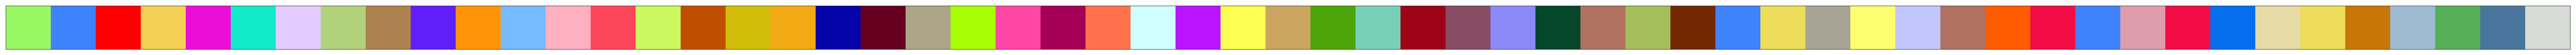

In [22]:
#mypal=[sns.xkcd_rgb[xkcol[i]] for i in random.sample(range(0, len(xkcol)), 15) ]
sns.palplot(pallete_20III)
plt.show()

##### Single cell loading, normalization and preprocess

In [179]:
%%time

#raw=pd.read_table('~/Downloads/Dalerba/exp1.txt',index_col=0,sep='\t')
#raw=pd.read_table('../Data/atac-seq.txt',index_col=0,sep='\t').T
#raw=pd.read_table('../Data/nuq-seq.txt',index_col=0,sep='\t').T
#raw=pd.read_table('../Data/',index_col=0,sep='\t')


name='dalerba_1'

CPU times: user 269 ms, sys: 35 ms, total: 304 ms
Wall time: 304 ms


In [805]:
#mitocondrial
mit=raw.columns[raw.columns.str.startswith('MT-')]

#spike-in
spkin=raw.columns[raw.columns.str.startswith('ERCC')]

raw.drop(spkin,axis=1,inplace=True)
raw.drop(mit,axis=1,inplace=True)

In [180]:
raw.shape

(350, 2000)

In [1092]:
raw=raw.loc[raw.T.sum()>5500]
raw.shape

(922, 49151)

In [25]:
raw=raw.loc[(raw.T>0).sum()>1500]    # filter out cells without any expression

raw=raw.loc[:,raw.sum()>0]        # filter out genes without any expression


dict_genes=dict(enumerate(raw.columns.values.tolist()))   # dictionary of genes names 
raw.columns=range(raw.shape[1])                           # genes by number
#raw.index=range(raw.shape[0])                             # cells by number

In [181]:
sortgenes=raw.mean().sort_values()     
raw=raw[sortgenes.index.tolist()]     # sort genes by expression in transcripts

sortcells=(raw.T>0).sum().sort_values()
raw=raw.loc[sortcells.index.tolist()]          # sort cells by average expression in transcripts

In [27]:
raw.columns=raw.columns.map(lambda x: dict_genes[x])

In [182]:
raw.shape

(350, 2000)

In [29]:
df=to_tpm(raw)
df=np.log2(1+df)
df=zscore_gene(df)

In [183]:
df=raw

In [184]:
%%time
Y=wishart_matrix(df)
(L,V)=get_eigen(Y)
Yrm=random_matrix(df)
Yr=wishart_matrix(Yrm)
(Lr,Vr)=get_eigen(Yr)

CPU times: user 244 ms, sys: 202 ms, total: 446 ms
Wall time: 147 ms


In [185]:
#import randomly as rm

/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


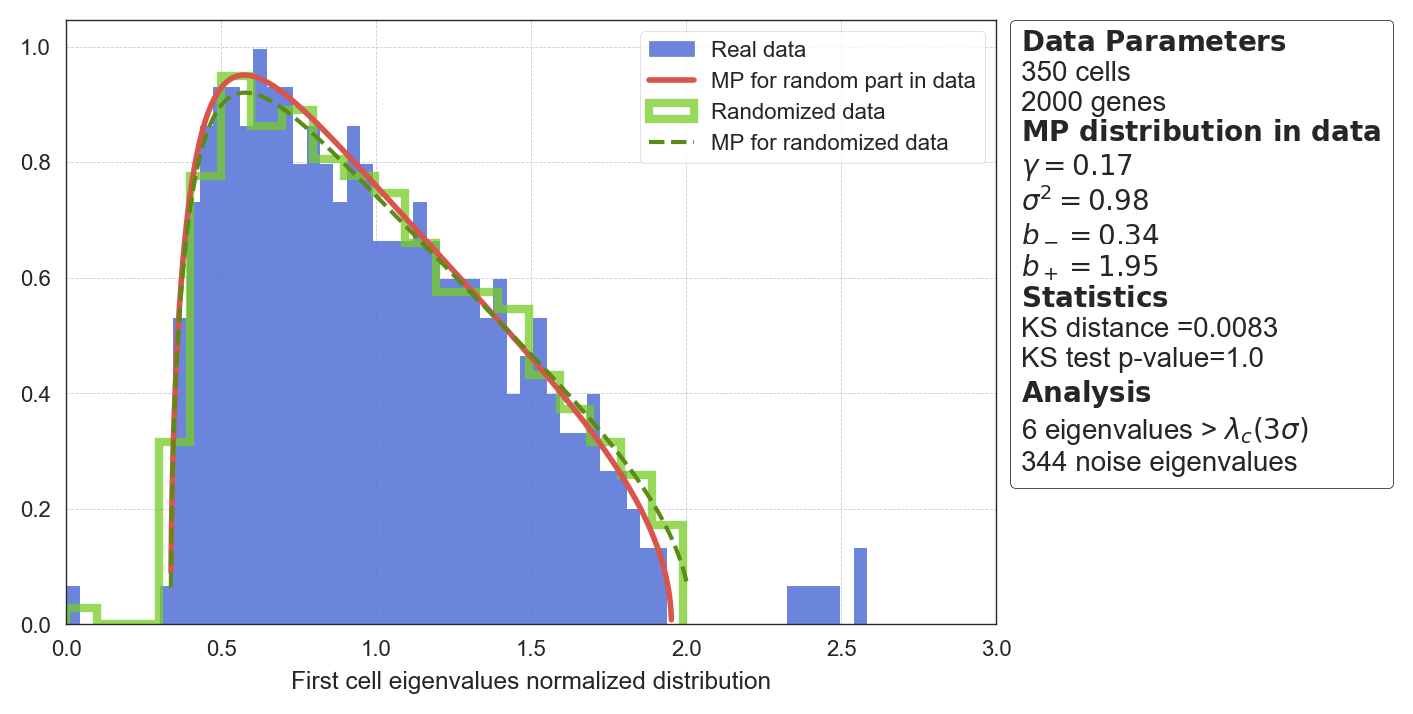

In [196]:
L2=mp_calculation(L,Lr)
mp_calculation_plot(L,Lr,L2,df,comparison=True,info=True,bins=60,bins2=20)
                  #  ,path='../{0}_MP_noclean.pdf'.format(name))

#### Localization phase transition

In [198]:
%%time
(dfc,df2)=cleaning(raw,df,3,listout=False)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [33]:
dfc.shape

(965, 10470)

In [34]:
Yc=wishart_matrix(df2)
(Lc,Vc) = get_eigen(Yc)
Yrmc=random_matrix(df2)
Yrc=wishart_matrix(Yrmc)
(Lrc,Vrc)=get_eigen(Yrc)

/Users/la2666/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/Users/la2666/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/Users/la2666/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/Users/la2666/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


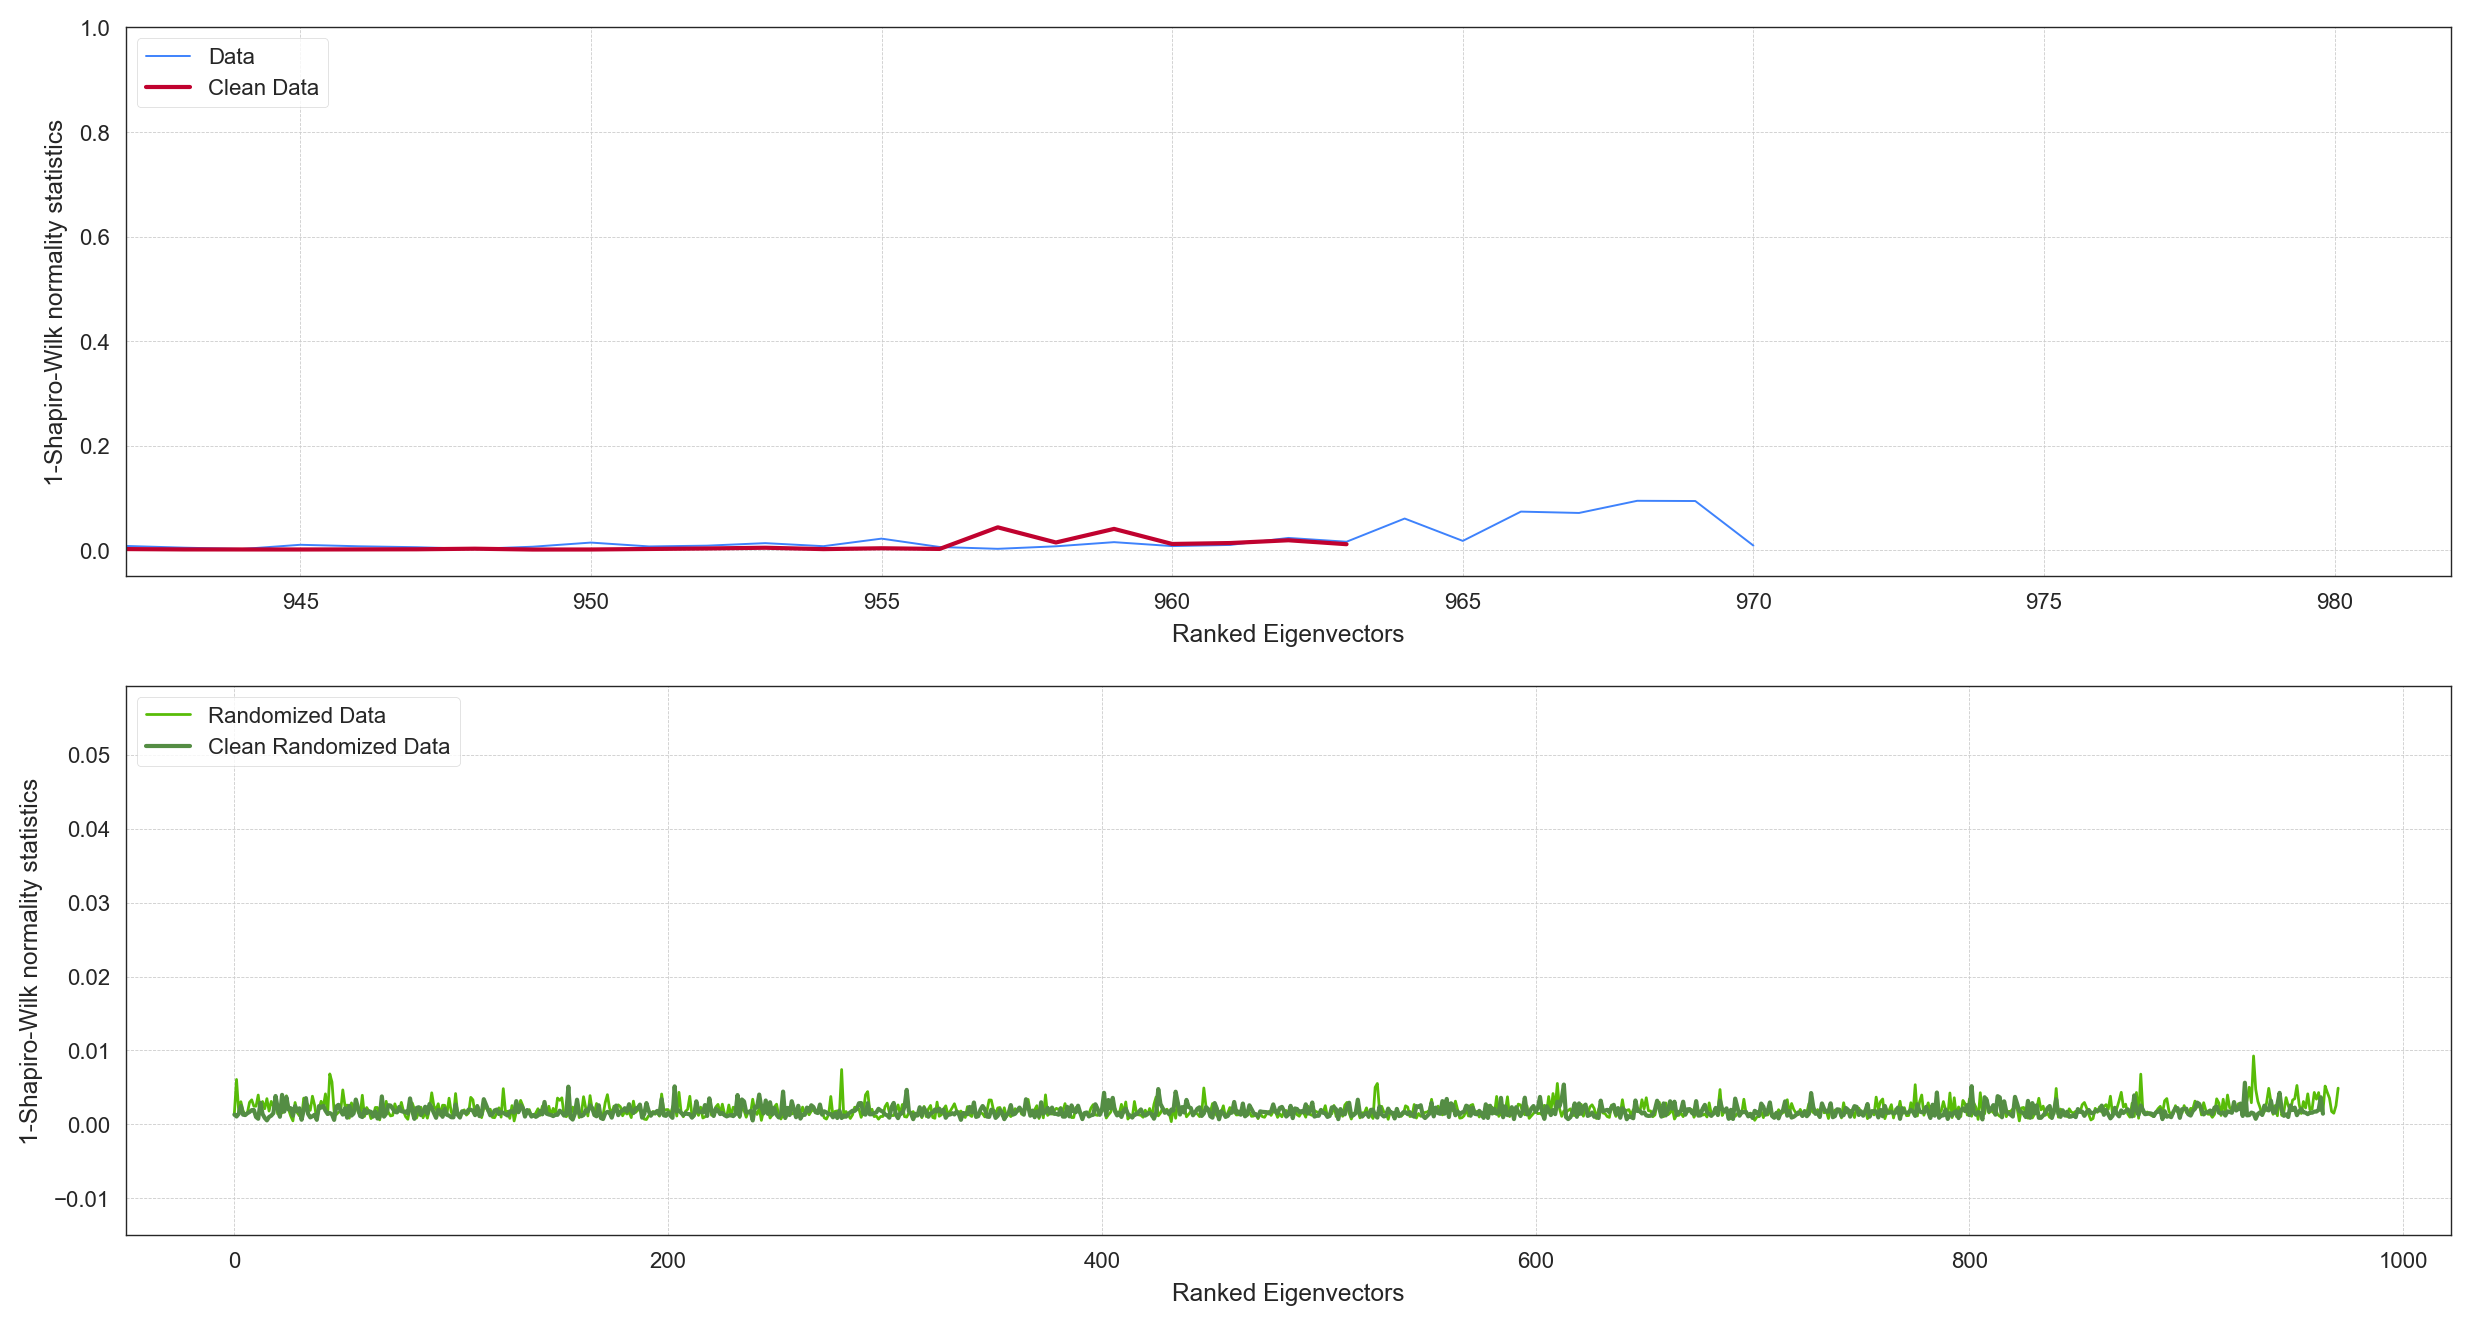

In [178]:
plot_localization(V,Vr,Vc,Vrc,zoom=30)
                  #,path='../../RandomMatrix/Supplementary Material/{0}_localization_zoom.pdf'.format(name))

/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


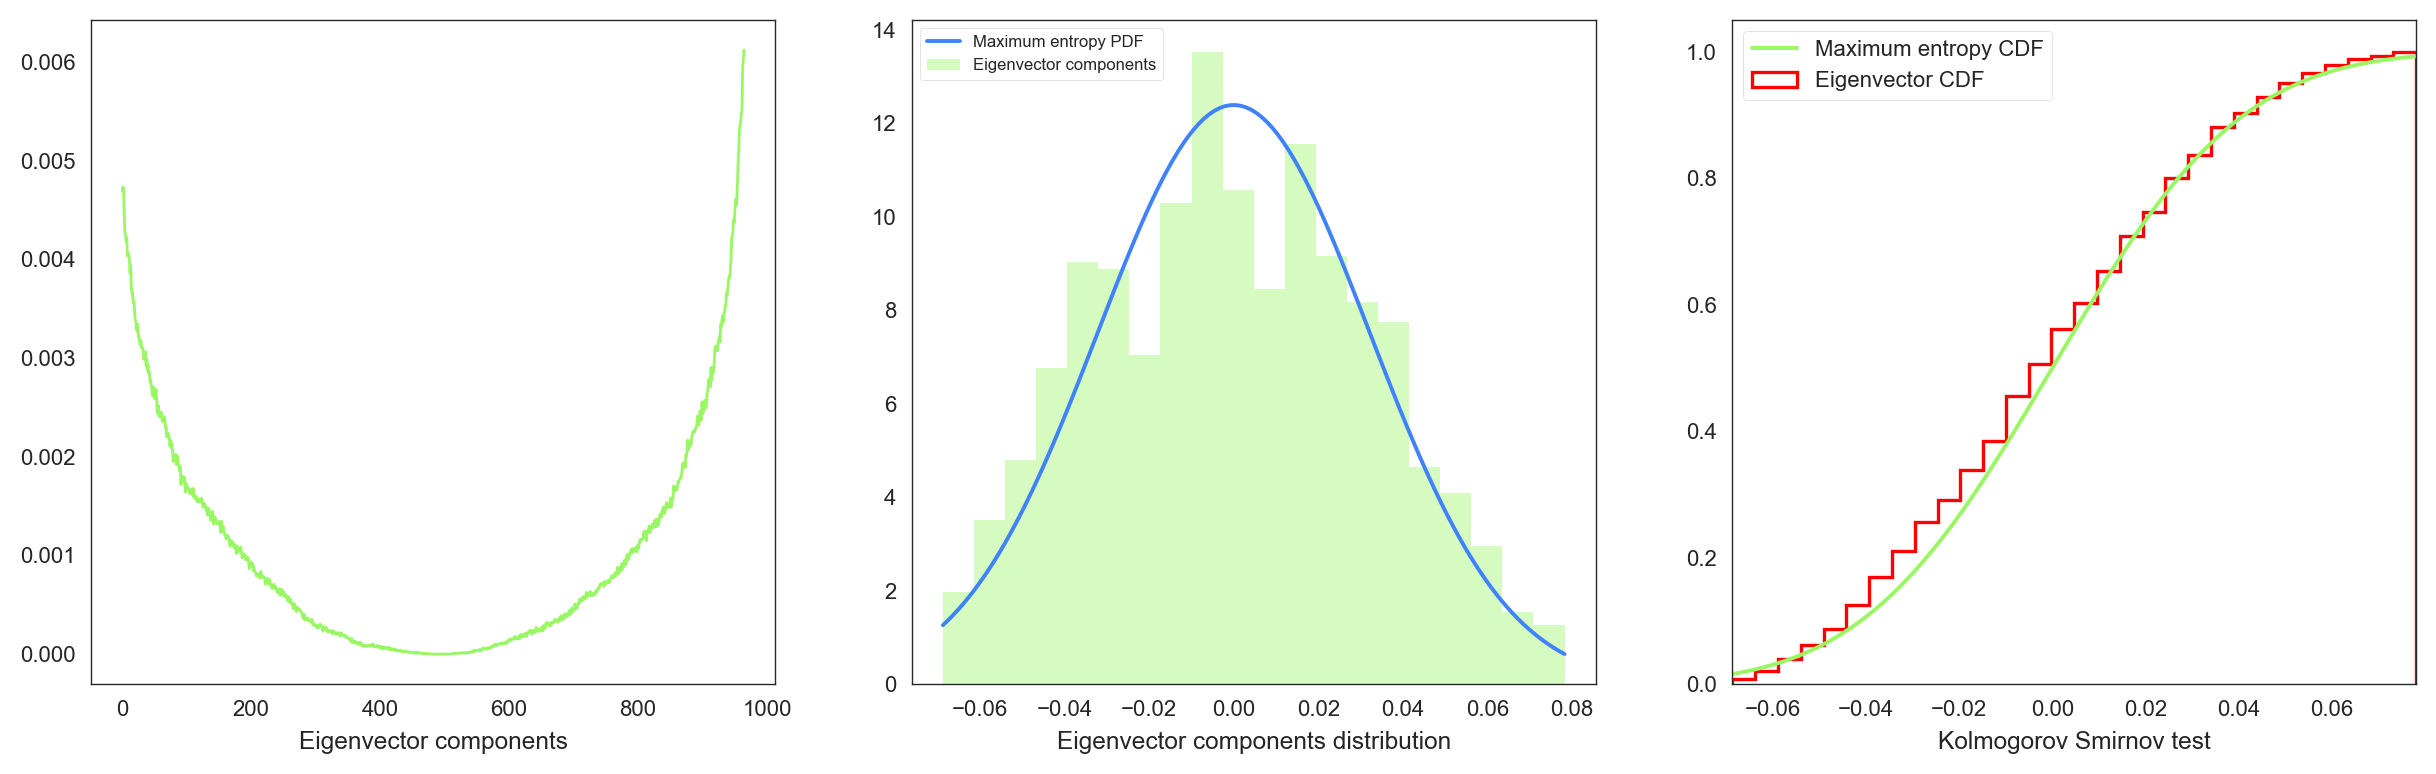

KstestResult(statistic=0.03821502052811865, pvalue=0.11635000200996837)

In [115]:
eign_entropy(Vc,len(Vc)-1)

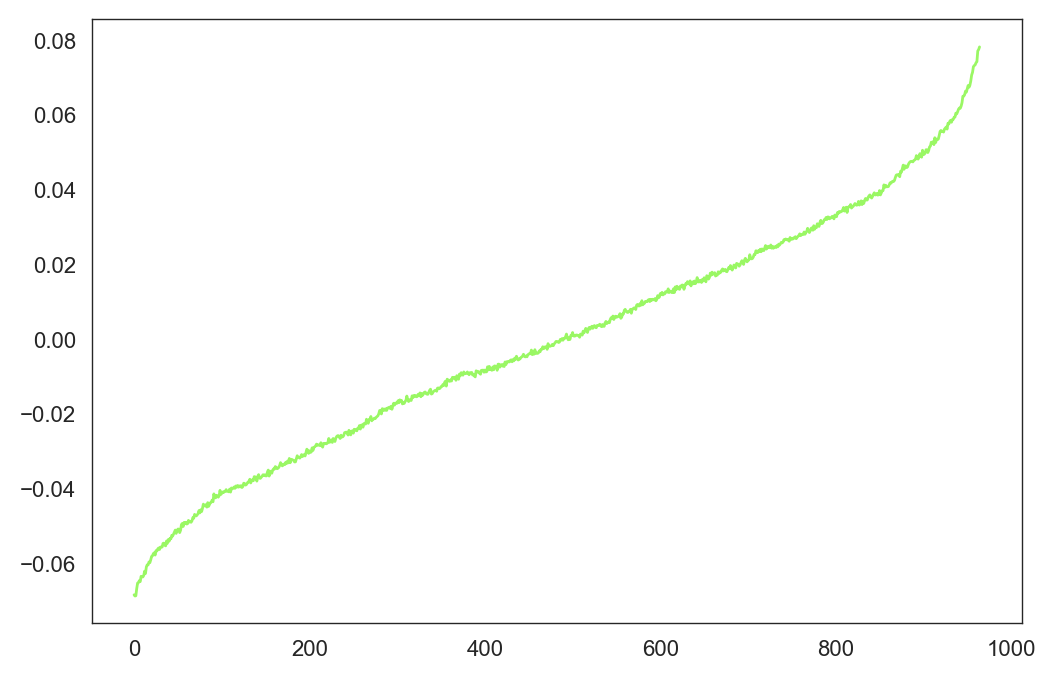

0.0010373443983402474

In [251]:
ex=pd.DataFrame(Vc.T[len(Vc)-1])[0]
pp=(ex).reset_index();
plt.plot(pp['index'].values,pp[0].values**1,lw=1)
#plt.ylim(-0.5,0.5)
plt.show()
ex.var()

/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


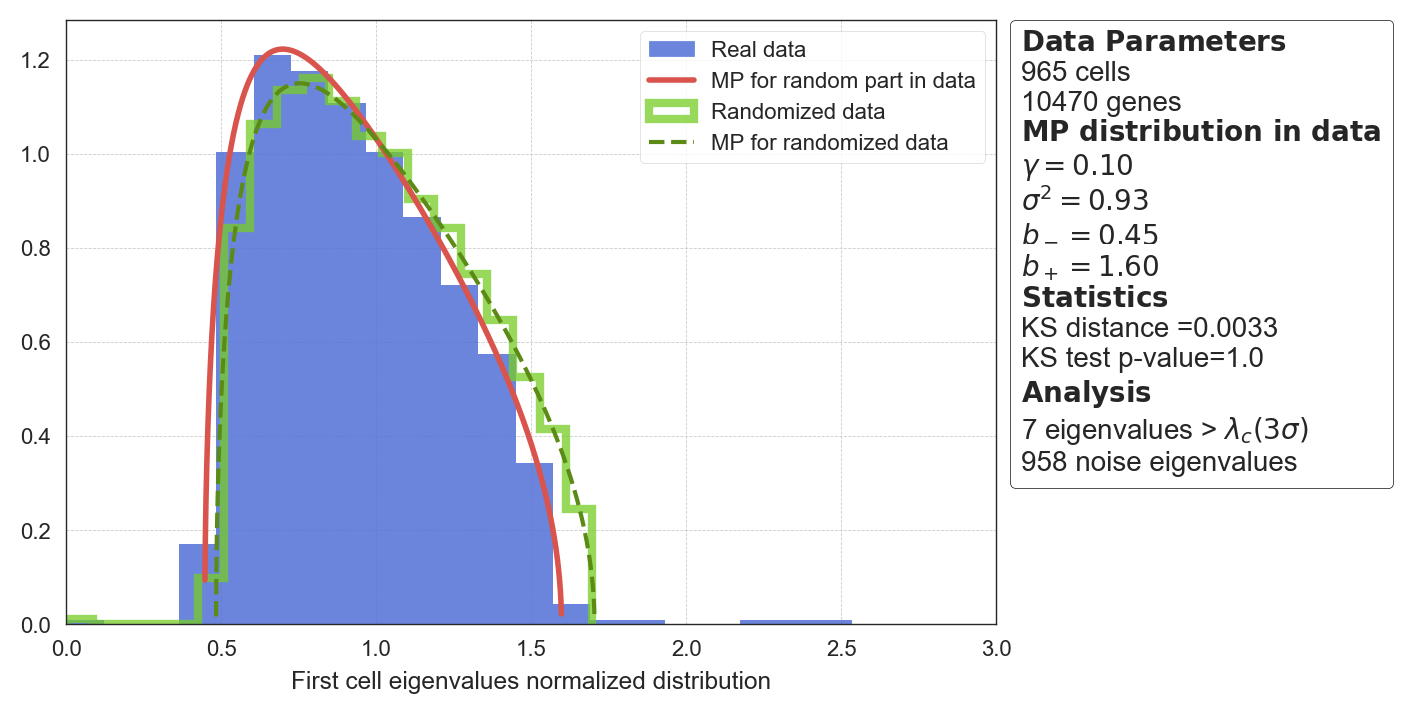

In [134]:
L2c=mp_calculation(Lc,Lrc)
mp_calculation_plot(Lc,Lrc,L2c,df2,comparison=True,info=True,bins=500,bins2=20
                  ,path='../{0}_MP_clean.pdf'.format(name))

/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/pyth

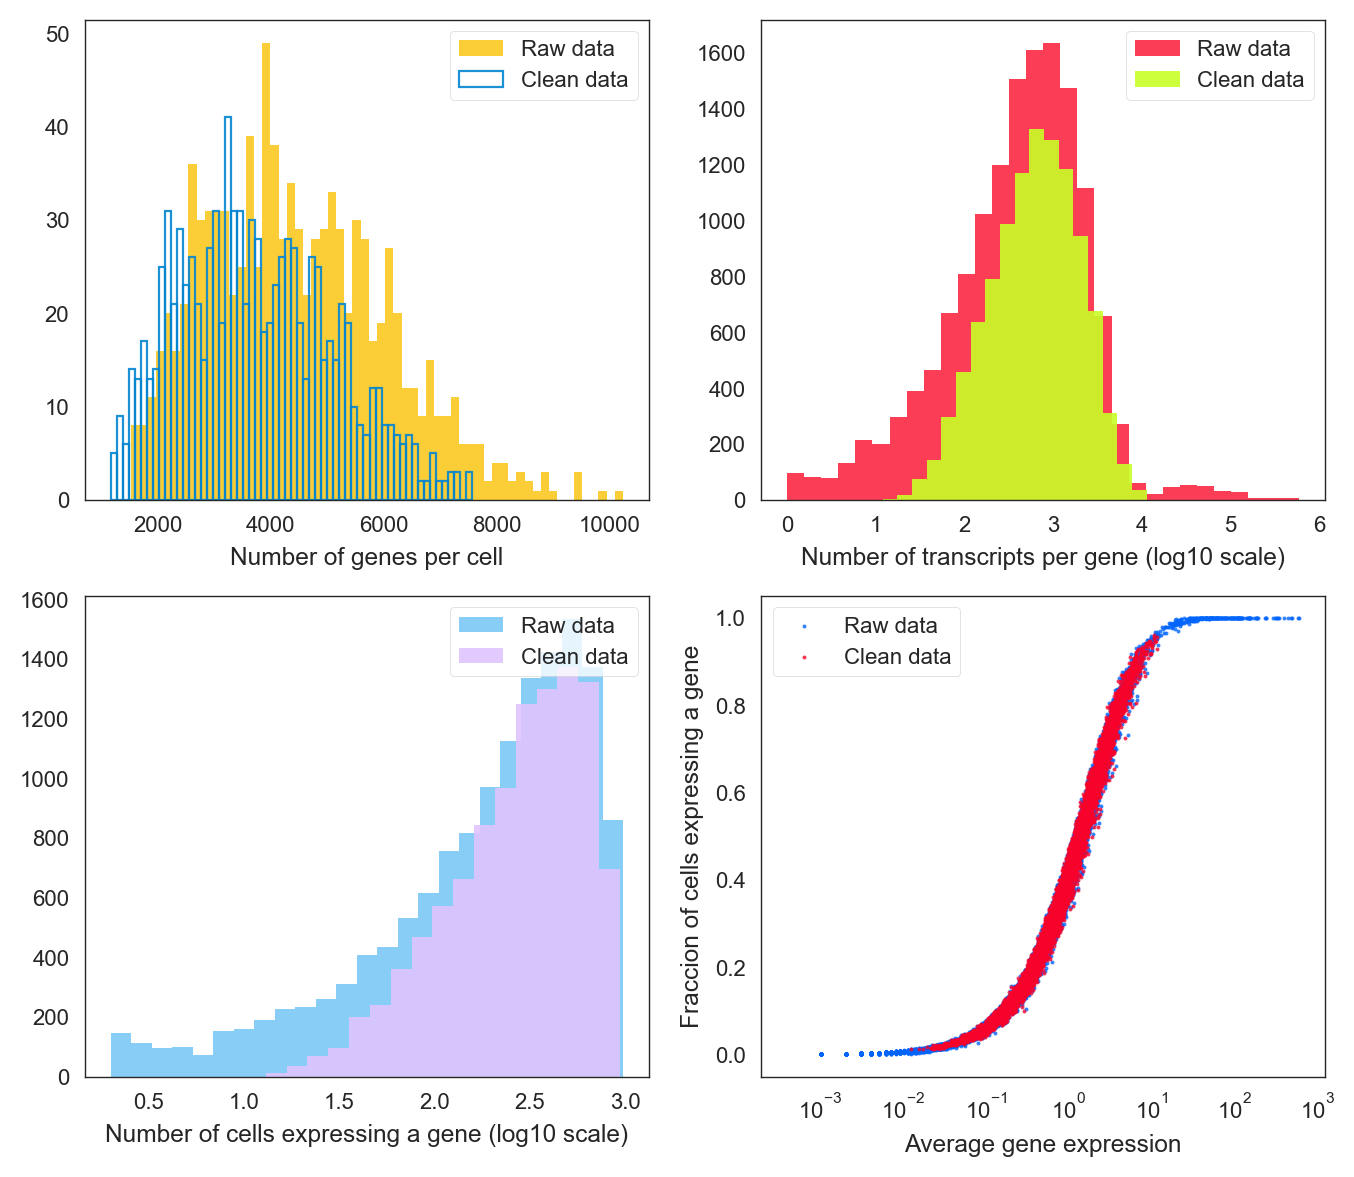

In [61]:
data_description(raw,dfc)#,path='../{0}_data_statistics.pdf'.format(name))

/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/la2666/anaconda2/lib/pyth

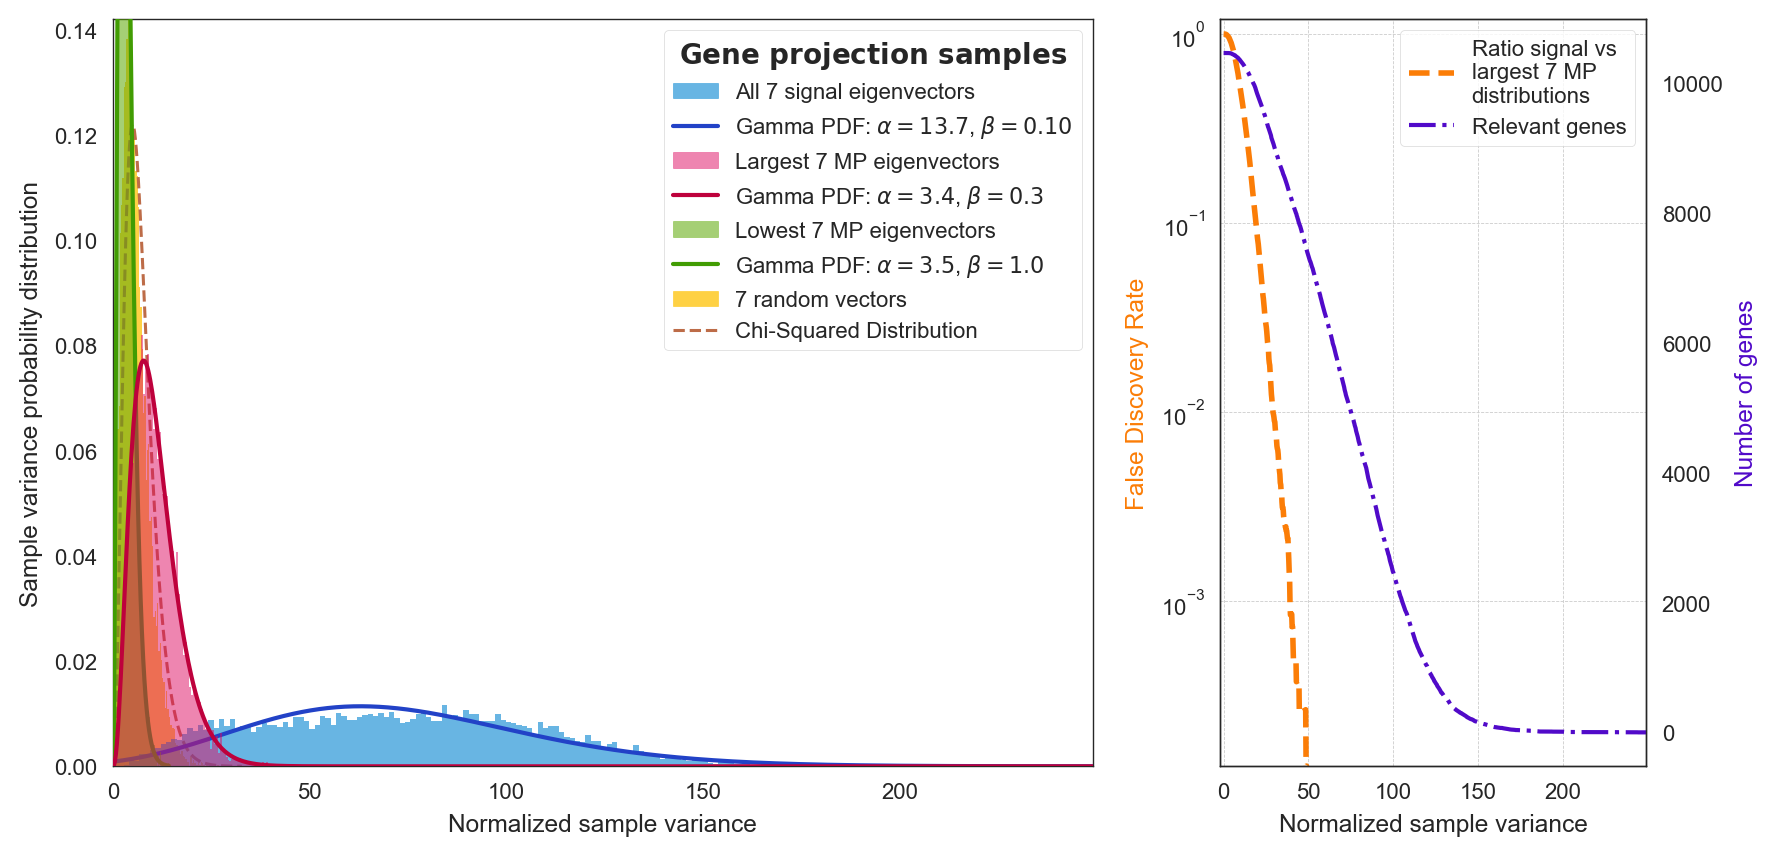

CPU times: user 7.34 s, sys: 978 ms, total: 8.31 s
Wall time: 3.99 s


In [62]:
%%time
plot_statistics(dfc,df2,Vrc,fit=True)
                #,path='../../RandomMatrix/Supplementary Material/{0}_Parametric_Statistics.pdf'.format(name))
                #,path='../New_figures/{0}_Parametric_Statistics.pdf'.format(name),fdr_cut=0.0001)

In [35]:
#df3=pd.read_table('../{0}_denoised_by_selection.txt'.format(name),sep='\t',index_col=0)
#df35=df3[df3.var().sort_values()[-4000:].index]
#df32=np.log2(1+to_tpm(df3))

In [216]:
%%time
#df2=np.log2(1+to_tpm(dfc))
#df2=zscore_gene(df2)
(U, S, V) = linalg.svd(df2, full_matrices=False)

#(U, S, V) = linalg.svd(df2[s_gen[s_gen>900].index.tolist()], full_matrices=False)

S[np.square(S)/df2.shape[1]<_tw(L2c,Lrc)]=0
#S[0]=0
df4=pd.DataFrame(np.dot(np.dot(U,np.diag(S)),V[:,:]))
#df4=pd.DataFrame(np.dot(np.dot(U[:,1:],np.diag(S[1:])),V[1:,:]))

df4.columns=df2.columns
df4.index=df2.index
#df4.to_csv('../{0}_denoised.txt'.format(name),sep='\t')

CPU times: user 231 ms, sys: 47.5 ms, total: 279 ms
Wall time: 117 ms


###  t-SNEs

In [224]:
(Ls,Vs,Ln,Vn)=get_significant_noise_eigen(df2)
dfp=project_genes(df2,Vs[:,:Vs.shape[1]-0])
s=np.square(dfp).sum(axis=1)
s_gen=pd.Series(s,index=df2.columns)

In [225]:
s1=set(s_gen[s_gen>50].index)
# s2=set(raw.var().sort_values(ascending=False)[0:700].index.tolist())
# s3=s1.intersection(s2)
print len(s1)

12


In [1119]:
tsne_max=run_tSNE_par(np.log2(1+to_tpm(dfc[s_gen[s_gen>200].index.tolist()]).dropna()),15,'euclidean',avoid=[0,2,3])

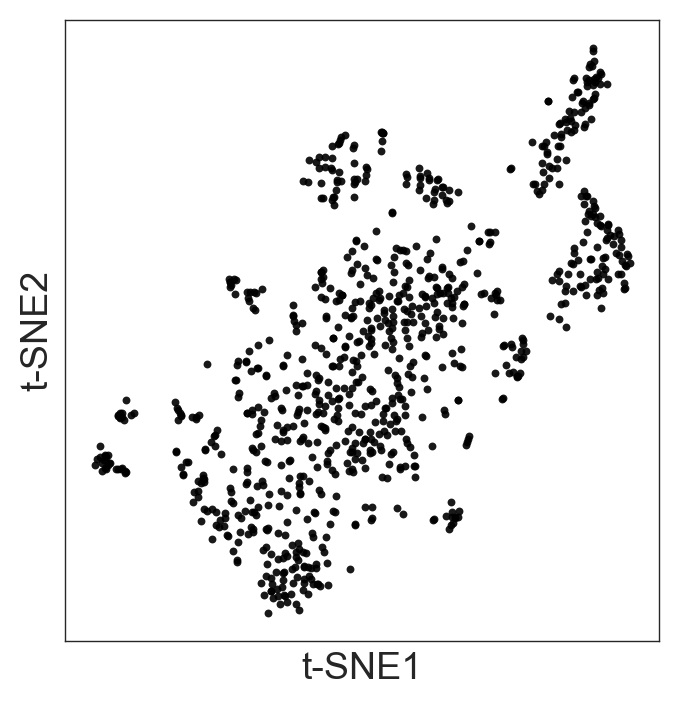

In [1120]:
plot_tSNE(tsne_max,size=4,psize=8,tight=False)

In [230]:
tsne_max_ns=run_tSNE_par(df4[s_gen[s_gen>50].index.tolist()],6,'correlation',pca=False,avoid=[])

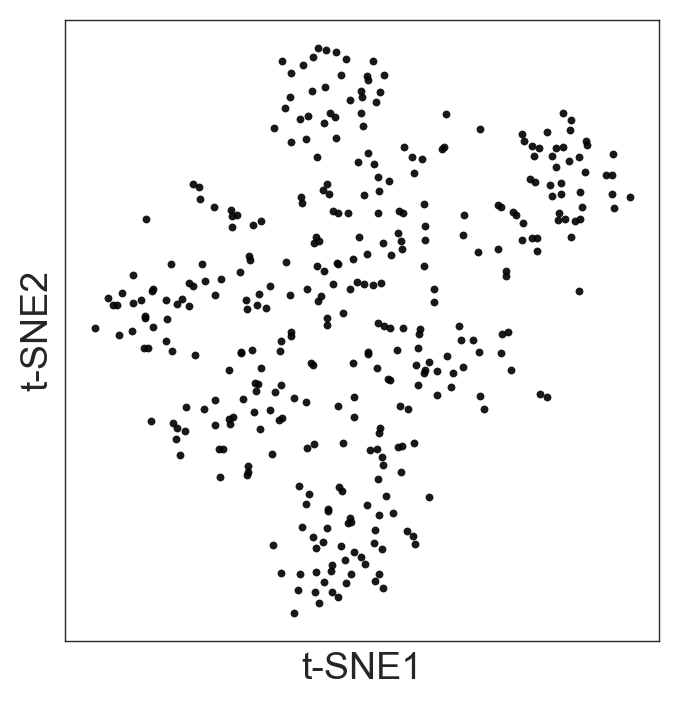

In [231]:
plot_tSNE(tsne_max_ns,size=4,psize=8,tight=False)

In [315]:
#plot_tSNE(tsne_seu,gene=['Ttr'],size=4)

In [129]:
esso=df4[s_gen[s_gen>40].index.tolist()]
#esso=np.log2(1+to_tpm(dfc[s_gen[s_gen>80].index.tolist()]).dropna())
esso2=esso.var()/esso.mean()
esso3=esso2.sort_values(ascending=False)[:].index.tolist()

In [130]:
pop=df4[esso3].T.corr(method='pearson')
h=hierarchical(pop,method='ward')

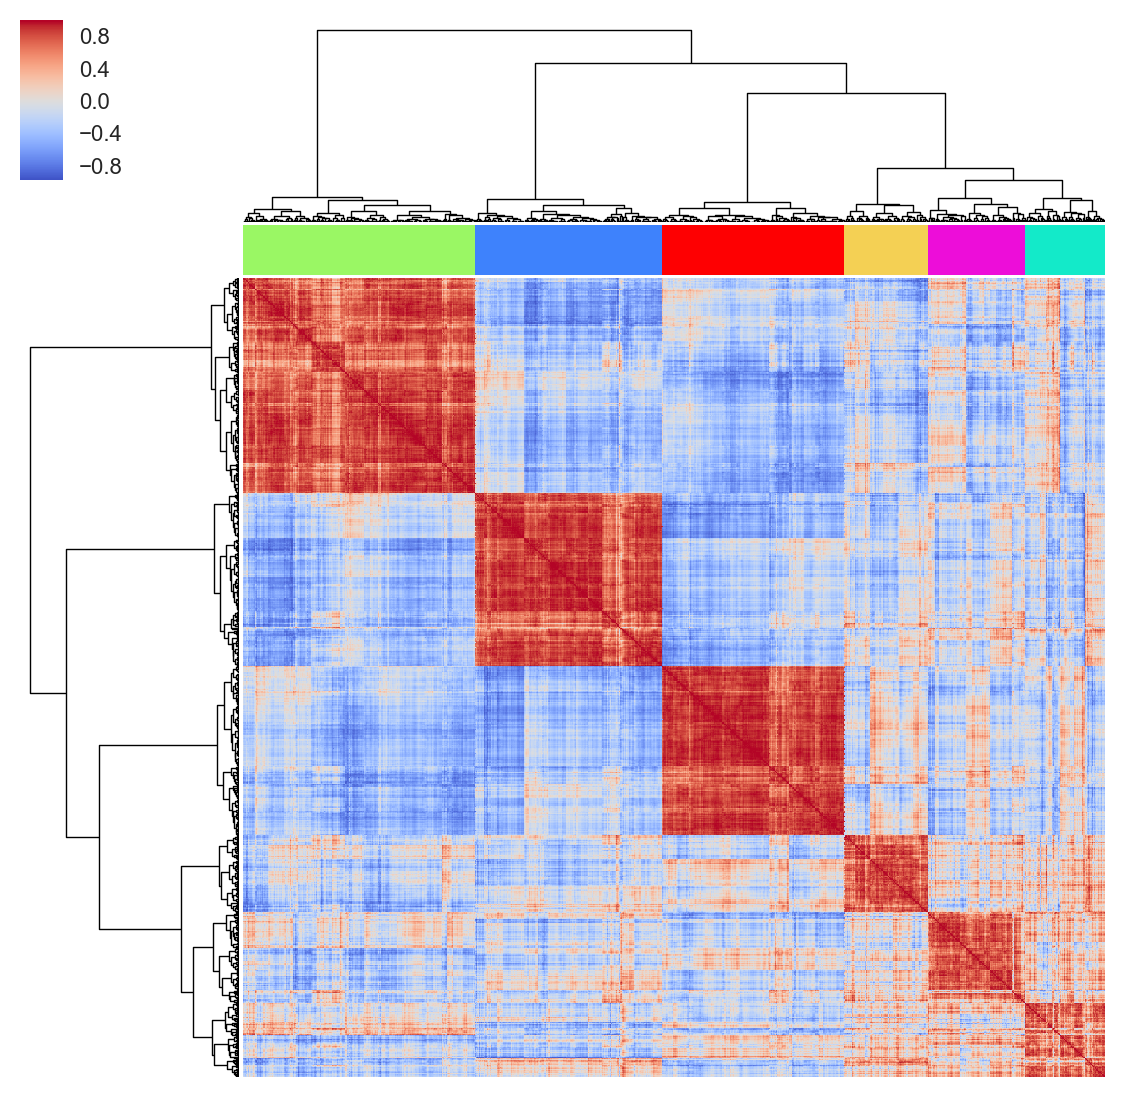

In [131]:
popul=populations(pop,h[0],h[1],thrs=60,ncolors=18,palette=pallete_20III)
                 #, cell_label=[dicol[i] for i in cortex_lab])
                 #,path='../../RandomMatrix/Supplementary Material/{0}_hierarchical.png'.format(name))

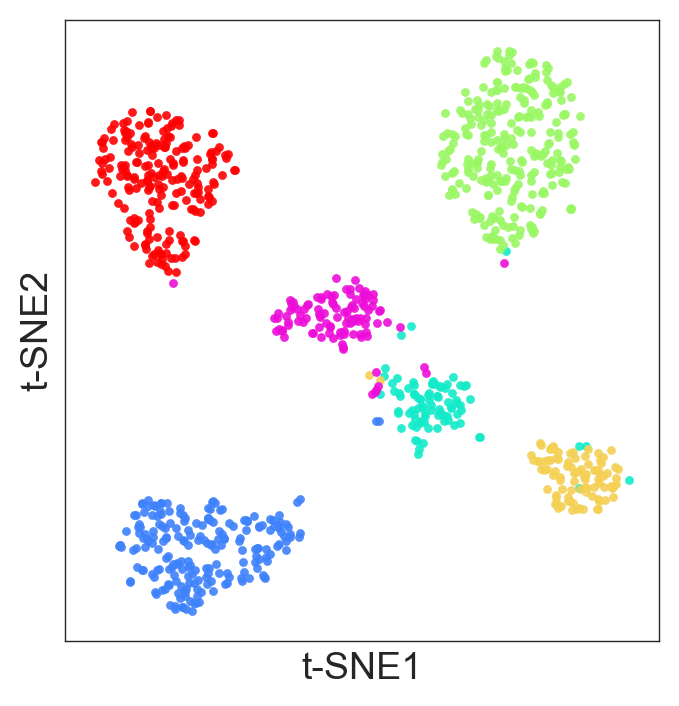

In [164]:
a=plot_populations(tsne_max_ns,popul,var='cell',cluster='all',get_cluster=True,size=4,psize=10,tight=False
                  ,path='../nuq-seq.pdf')

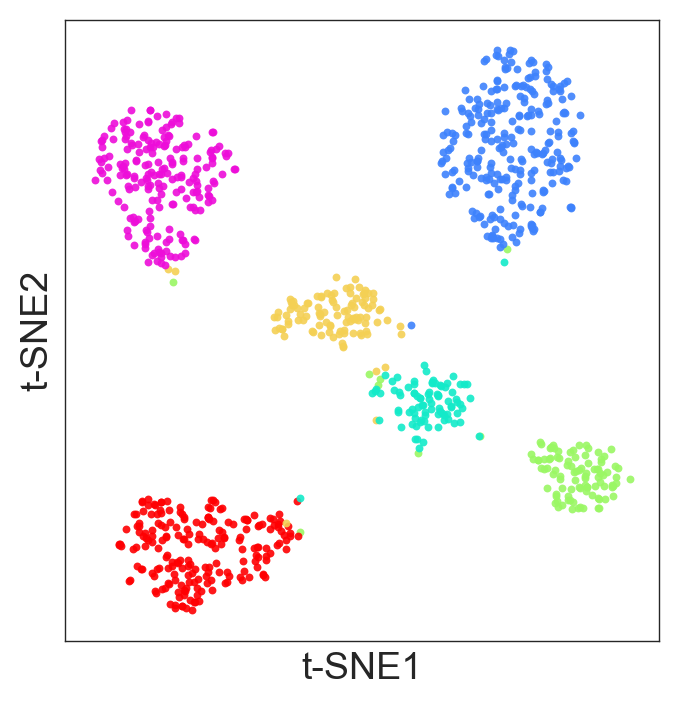

In [114]:
plot_clusters('kmeans',6,tsne_max_ns,esso,get_cluster=False,size=4,psize=8,palette=pallete_20III,tight=False)

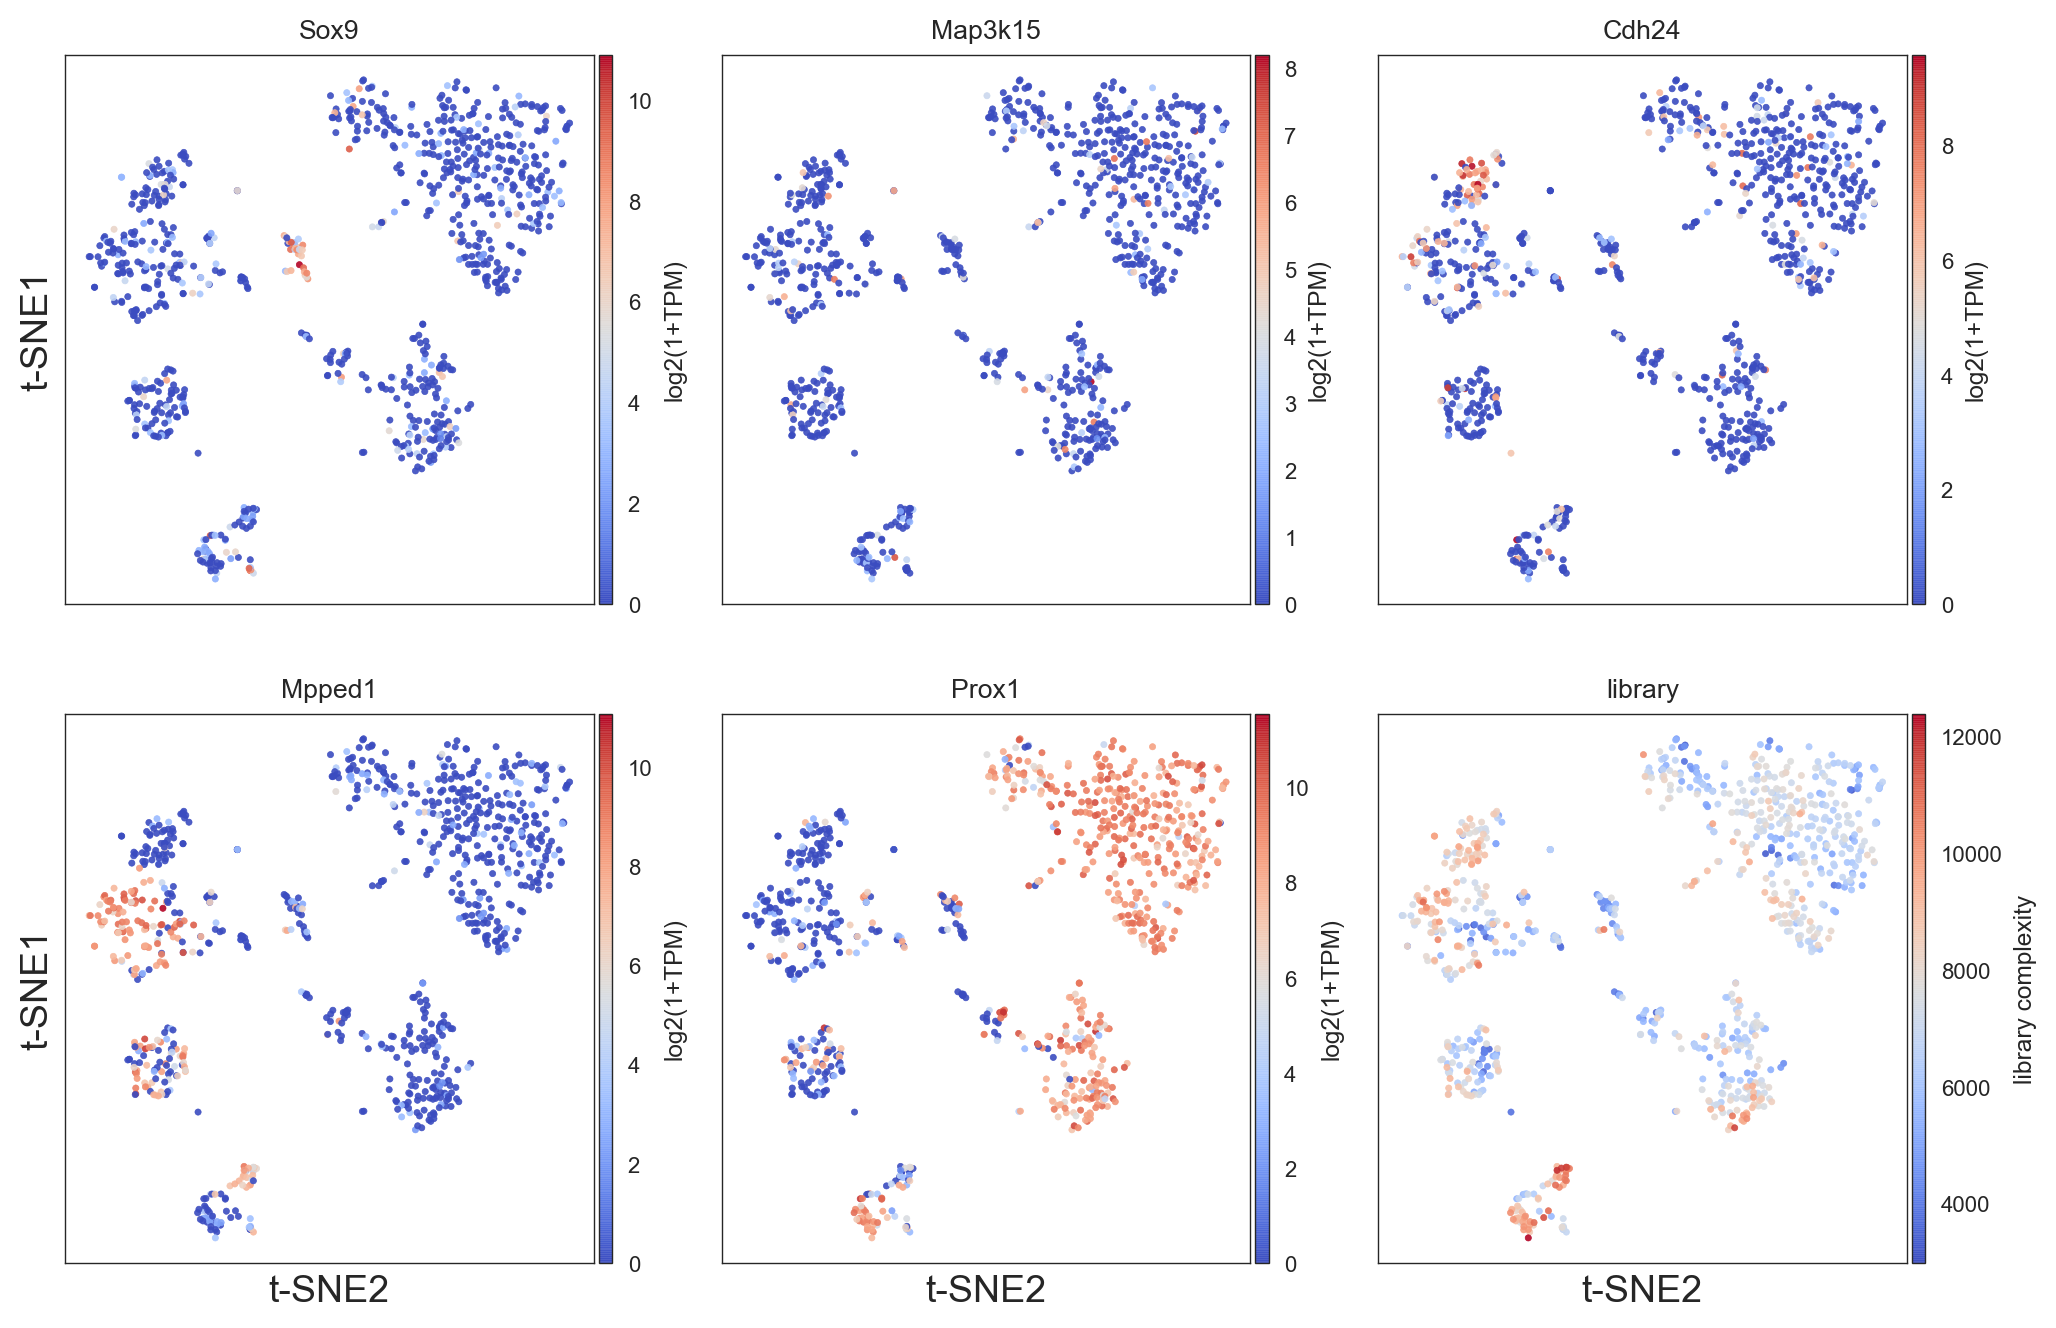

In [1246]:
plot_tSNE(tsne_max_ns,gene=('Sox9','Map3k15','Cdh24','Mpped1','Prox1','library'),data=np.log2(1+to_tpm(raw)),size=4,tight=False)

In [1151]:
#cell cycle and library
plot_tSNE(tsne_max_ns,gene=('PCNA', 'TOP2A', 'MCM6', 'MKI67','library'),size=4,psize=8,tight=False)

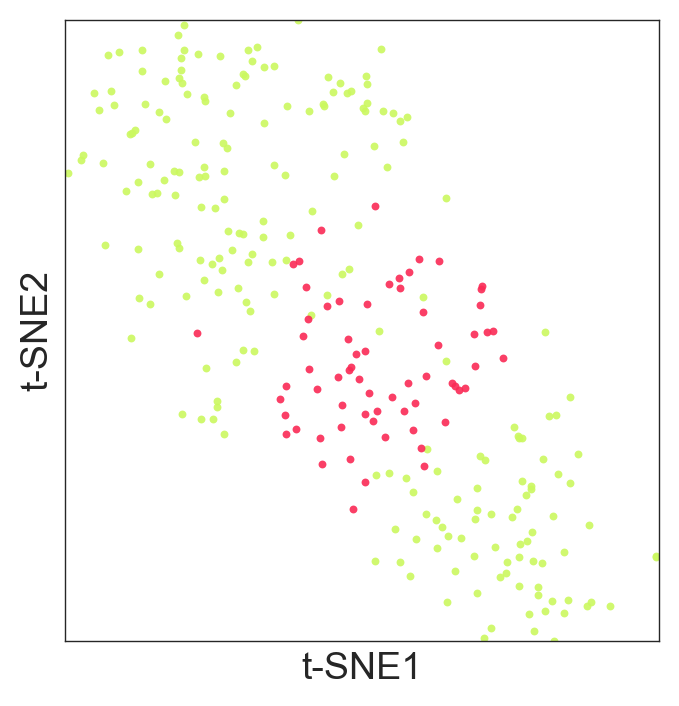

66

In [982]:
mya=plot_populations(tsne_max_ns,popul,var='cell',cluster=4,get_cluster=True,size=4,psize=8)
len(mya)

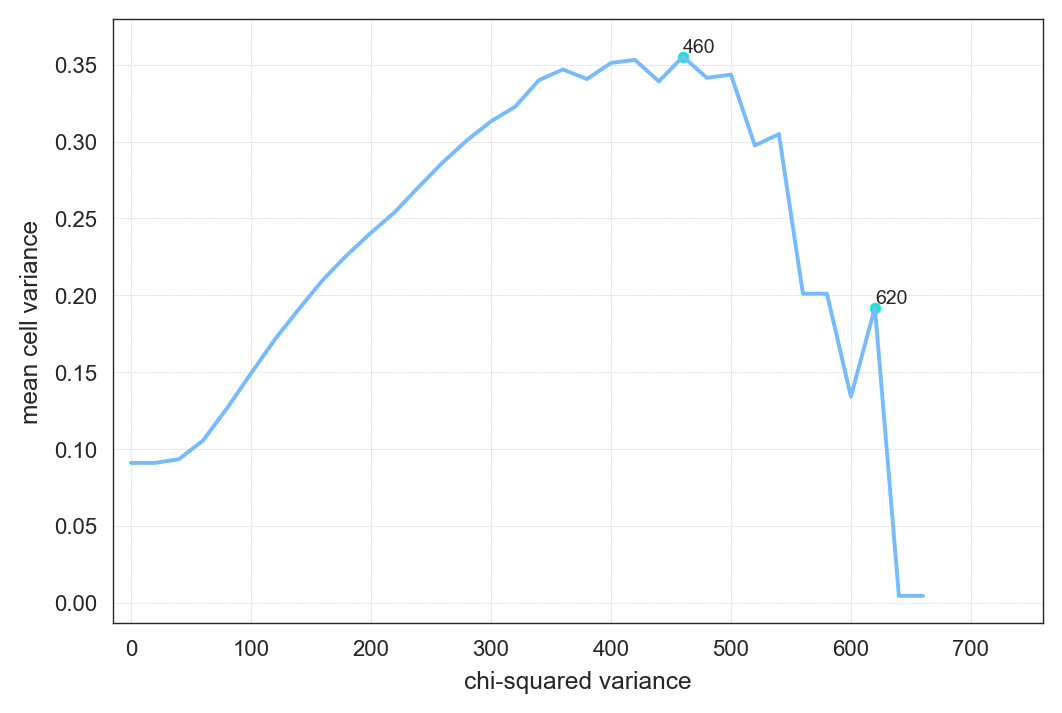

In [1193]:
ello2=[]
scope=range(0,int(round(max(s))),20)
for i in scope:
    esso=df4[s_gen[s_gen>i].index.tolist()].T
    ello2.append(esso.var().median())
    #ello2.append((esso.var()/esso.mean()).mean())

vval=ello2
maxs=detect_pick(vval,scope,0.03,'max')
plt.xlabel('chi-squared variance')
plt.ylabel('mean cell variance')
plt.scatter(maxs[0],maxs[1],s=15,zorder=0)
plt.plot(scope,vval,zorder=1,color=sns.xkcd_rgb["sky blue"])
plt.grid(b=True, linestyle='--',lw=0.2)
#plt.ylim(0,max(vval)+20)
plt.xlim(-15,max(scope)+20)
for i in range(0,len(maxs[0])):
    plt.text(maxs[0][i], maxs[1][i]+0.003, maxs[0][i], fontsize=7)
#plt.savefig('../{0}_cell_var_nul.pdf'.format(name))
plt.show()

In [1016]:
#Info for the user

mat=df4[s_gen[s_gen>1500].index.tolist()]

mat=mat.applymap(lambda x: round(x,3))
mat.loc[a.index,'clust']=a.loc[:,0]
mat.to_csv('../New_figures/mouse_cortex/clusters/{0}_clusters2.txt'.format(name),sep='\t')

In [ ]:
#gene projection
raw.drop(mit,axis=1,inplace=True)

/Users/la2666/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


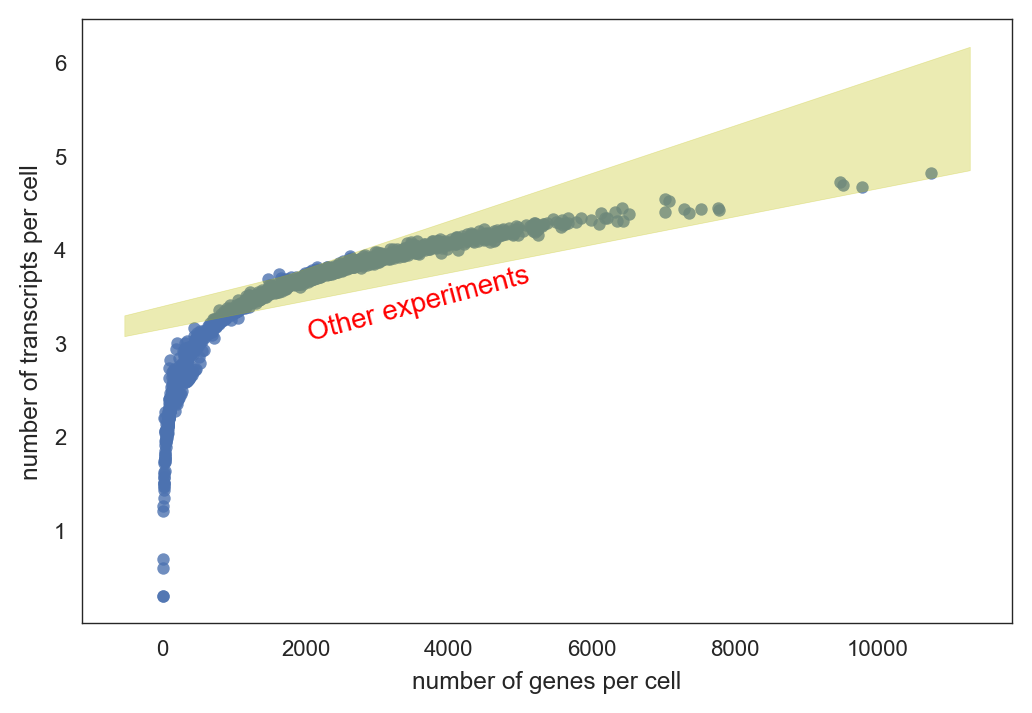

In [304]:
exp=raw.T
plt.figure()
#plt.scatter((df!=0).sum(), np.log10(df.sum()), s=20, cmap="Spectral"); #set style options

plot= sns.regplot((exp!=0).sum(), np.log10(exp.sum()), scatter=True,fit_reg=False, scatter_kws={'s':20}); 
plot.set(ylabel='number of transcripts per cell', xlabel='number of genes per cell')

X_plot = np.linspace(plot.axes.get_xlim()[0],plot.axes.get_xlim()[1],100)

m=0.00015#0.00020
b=3.156
peter=m*X_plot + b
#plt.plot(X_plot, peter, linewidth=2)
m=0.00019
b=3.4
sagi=m*X_plot + b
#plt.plot(X_plot, sagi, linewidth=2)
m=0.000255
b=3.29
stavruola=m*X_plot + b
#plt.plot(X_plot,stavruola, linewidth=2)
y4 = np.maximum(stavruola, sagi)
plt.fill_between(X_plot, y4, peter,color='y',alpha=.3)

plt.text(2000, 3.65,'Other experiments', fontsize=10, color='r',rotation=15) #add text
#plt.savefig('Plots/'+sample+'_quality.pdf')

#sns.jointplot((df!=0).sum(), np.log10(df.sum()),marginal_kws=dict(bins=30),stat_func=None); 
plt.show()

In [238]:
tsne_raw=run_tSNE_par(df,300,'euclidean',avoid=[])

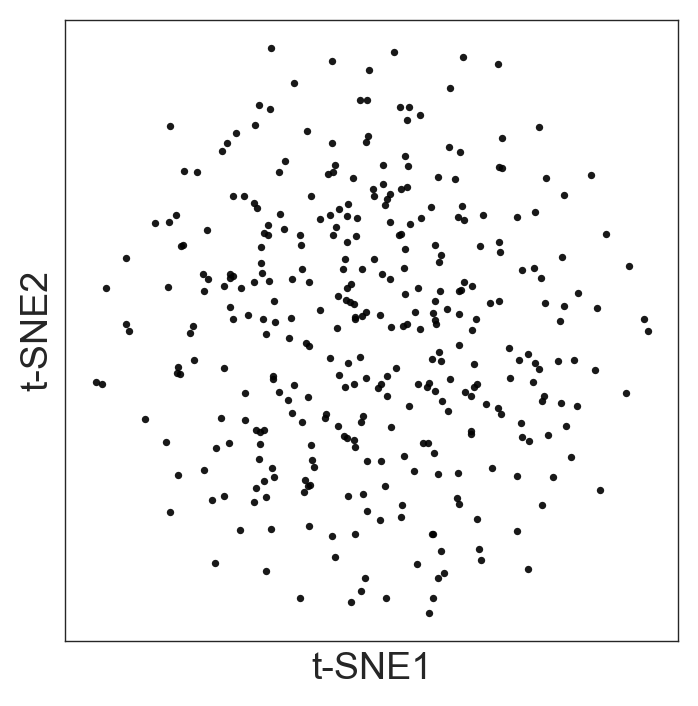

In [241]:
plot_tSNE(tsne_raw,size=4,psize=7,tight=False)#,path='../non_clean.pdf')

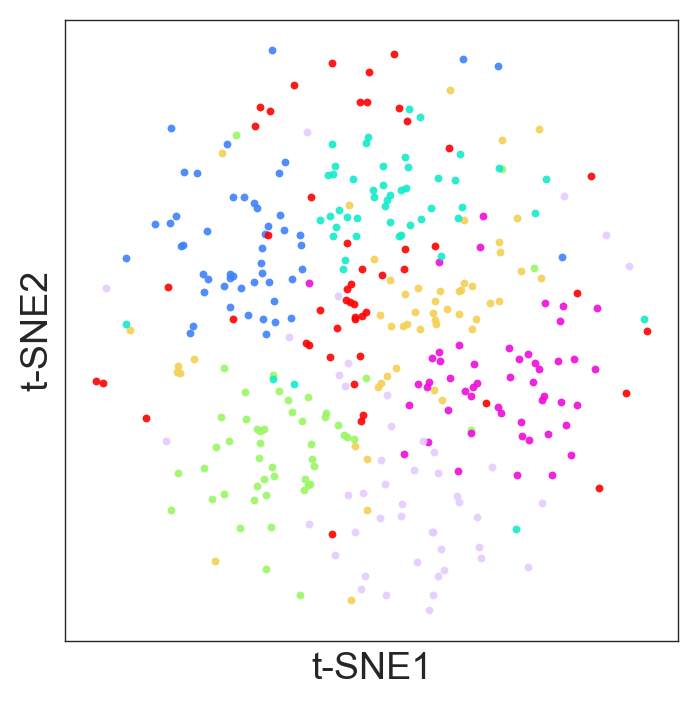

In [250]:
plot_clusters('kmeans',7,tsne_raw,a,get_cluster=False,size=4,psize=8,palette=pallete_20III,tight=False,path='../sim2_2.pdf')

In [249]:
a=pca(100,df)